- Anmol More - 11915043
- Shlok Mittal - 11915071

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import svm

#Ref : https://towardsdatascience.com/analyzing-time-series-data-in-pandas-be3887fdd621

In [2]:
%%time
df = pd.read_csv('../data/raw/cabdata_v2.csv')
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
print(df.dtypes)
df.shape

Unnamed: 0                   int64
CALL_TYPE                   object
DAY_TYPE                    object
MISSING_DATA                  bool
ORIGIN_CALL                float64
ORIGIN_STAND               float64
POLYLINE                    object
TAXI_ID                      int64
TIMESTAMP           datetime64[ns]
TRIP_ID                      int64
end_coordinate              object
start_coordinate            object
start_lat                  float64
start_long                 float64
end_lat                    float64
end_long                   float64
dtype: object
CPU times: user 18.3 s, sys: 3.24 s, total: 21.6 s
Wall time: 22 s


(1674160, 16)

In [3]:
df = df[['CALL_TYPE','ORIGIN_STAND','TAXI_ID','TIMESTAMP','TRIP_ID',
         'end_coordinate','start_coordinate','start_lat','start_long',
         'end_lat','end_long']]

In [4]:
df_taxi_stand = df[df['CALL_TYPE'] == 'B']
df_taxi_stand = df_taxi_stand[['TIMESTAMP','ORIGIN_STAND','start_coordinate','end_coordinate',
                              'start_lat','start_long','end_lat','end_long']]
df_taxi_stand.head()

TIMESTAMP  ORIGIN_STAND        start_coordinate  \
1  2013-07-01 00:08:23           7.0  [-8.639847, 41.159826]   
15 2013-07-01 00:13:30          13.0  [-8.585145, 41.164857]   
16 2013-07-01 00:28:01          28.0  [-8.584263, 41.163156]   
23 2013-07-01 00:52:40          38.0   [-8.60418, 41.160969]   
28 2013-07-01 00:47:15          52.0  [-8.613243, 41.154444]   

            end_coordinate  start_lat  start_long    end_lat  end_long  
1    [-8.66574, 41.170671]  41.159826   -8.639847  41.170671 -8.665740  
15  [-8.628147, 41.157522]  41.164857   -8.585145  41.157522 -8.628147  
16  [-8.641566, 41.142672]  41.163156   -8.584263  41.142672 -8.641566  
23  [-8.579763, 41.167899]  41.160969   -8.604180  41.167899 -8.579763  
28  [-8.613315, 41.166891]  41.154444   -8.613243  41.166891 -8.613315

In [5]:
df_taxi_stand['DATE'] = df_taxi_stand.TIMESTAMP.dt.date
df_taxi_stand['DAY OF WEEK'] = df_taxi_stand.TIMESTAMP.dt.weekday_name
df_taxi_stand['HOUR'] = df_taxi_stand.TIMESTAMP.dt.hour
df_taxi_stand['MINUTE'] = df_taxi_stand.TIMESTAMP.dt.minute
df_taxi_stand.sample(5)

TIMESTAMP  ORIGIN_STAND        start_coordinate  \
480641  2013-10-14 13:28:07          33.0  [-8.600094, 41.182677]   
1390354 2014-05-05 14:04:19          23.0  [-8.612613, 41.146056]   
645492  2013-11-19 07:55:31          35.0  [-8.649477, 41.167242]   
1641129 2014-06-24 04:27:11          52.0  [-8.613252, 41.154354]   
1389412 2014-05-05 09:30:51          15.0  [-8.585676, 41.148648]   

                 end_coordinate  start_lat  start_long    end_lat  end_long  \
480641   [-8.555787, 41.215797]  41.182677   -8.600094  41.215797 -8.555787   
1390354  [-8.646174, 41.154309]  41.146056   -8.612613  41.154309 -8.646174   
645492   [-8.620389, 41.146974]  41.167242   -8.649477  41.146974 -8.620389   
1641129   [-8.62587, 41.150727]  41.154354   -8.613252  41.150727 -8.625870   
1389412  [-8.607105, 41.150403]  41.148648   -8.585676  41.150403 -8.607105   

               DATE DAY OF WEEK  HOUR  MINUTE  
480641   2013-10-14      Monday    13      28  
1390354  2014-05-05      Monday    14       4  
645492   2013-11-19     Tuesday     7      55  
1641129  2014-06-24     Tuesday     4      27  
1389412  2014-05-05      Monday     9      30

In [6]:
df_taxi_stand['Total Trip Count'] = df_taxi_stand.groupby(['ORIGIN_STAND'])['ORIGIN_STAND'].transform('count')
df_taxi_stand['Trip Count Daily'] = df_taxi_stand.groupby(['DATE','ORIGIN_STAND'])['ORIGIN_STAND'].transform('count')
df_taxi_stand['Mean Trip Count Daily'] = df_taxi_stand.groupby(['ORIGIN_STAND'])['Trip Count Daily'].transform('mean')
df_taxi_stand['Trip Count Hourly'] = df_taxi_stand.groupby(['DATE', 'ORIGIN_STAND', 'HOUR'])['DATE'].transform('count')
df_taxi_stand['Mean Trip Count Hourly'] = df_taxi_stand.groupby(['ORIGIN_STAND', 'HOUR'])['Trip Count Hourly'].transform('mean')

In [7]:
df_taxi_stand[df_taxi_stand['ORIGIN_STAND'] == 15].head()

TIMESTAMP  ORIGIN_STAND        start_coordinate  \
62  2013-07-01 01:20:00          15.0  [-8.585811, 41.148666]   
408 2013-07-01 06:07:49          15.0  [-8.585604, 41.148585]   
433 2013-07-01 06:12:08          15.0  [-8.585667, 41.148549]   
484 2013-07-01 06:19:31          15.0  [-8.585658, 41.148531]   
485 2013-07-01 05:53:47          15.0  [-8.585604, 41.148576]   

             end_coordinate  start_lat  start_long    end_lat  end_long  \
62   [-8.580492, 41.164884]  41.148666   -8.585811  41.164884 -8.580492   
408  [-8.670051, 41.236875]  41.148585   -8.585604  41.236875 -8.670051   
433  [-8.591337, 41.156289]  41.148549   -8.585667  41.156289 -8.591337   
484  [-8.604081, 41.182533]  41.148531   -8.585658  41.182533 -8.604081   
485   [-8.66907, 41.177214]  41.148576   -8.585604  41.177214 -8.669070   

           DATE DAY OF WEEK  HOUR  MINUTE  Total Trip Count  Trip Count Daily  \
62   2013-07-01      Monday     1      20           79653.0             256.0   
408  2013-07-01      Monday     6       7           79653.0             256.0   
433  2013-07-01      Monday     6      12           79653.0             256.0   
484  2013-07-01      Monday     6      19           79653.0             256.0   
485  2013-07-01      Monday     5      53           79653.0             256.0   

     Mean Trip Count Daily  Trip Count Hourly  Mean Trip Count Hourly  
62              227.565503                1.0                3.973306  
408             227.565503                5.0                4.637140  
433             227.565503                5.0                4.637140  
484             227.565503                5.0                4.637140  
485             227.565503                2.0                3.934783

In [8]:
print(df_taxi_stand.ORIGIN_STAND.value_counts())
taxi_plot_df = pd.DataFrame()

taxi_stands = df_taxi_stand['ORIGIN_STAND'].unique()
for stand in taxi_stands :
    df_temp = df_taxi_stand[df_taxi_stand['ORIGIN_STAND'] == stand]
    if(df_temp.shape[0] > 0) :
        df_temp = df_temp.sample(1)
        df_temp = df_temp[['ORIGIN_STAND','start_coordinate', 'start_lat', 'start_long','Total Trip Count']]
        taxi_plot_df = taxi_plot_df.append(df_temp)
    
taxi_plot_df
#df_taxi_stand.ORIGIN_STAND.nunique(dropna = True)

15.0    79653
57.0    50184
9.0     34479
33.0    33756
23.0    33073
        ...  
41.0      493
43.0      490
8.0       373
5.0        49
48.0        6
Name: ORIGIN_STAND, Length: 63, dtype: int64


ORIGIN_STAND        start_coordinate  start_lat  start_long  \
20849             7.0  [-8.639982, 41.159754]  41.159754   -8.639982   
1397279          13.0  [-8.628183, 41.157306]  41.157306   -8.628183   
60162            28.0  [-8.584299, 41.163255]  41.163255   -8.584299   
1173068          38.0  [-8.604189, 41.161086]  41.161086   -8.604189   
883750           52.0  [-8.613261, 41.154327]  41.154327   -8.613261   
...               ...                     ...        ...         ...   
487211           46.0  [-8.649036, 41.178456]  41.178456   -8.649036   
1338797          41.0  [-8.676072, 41.163273]  41.163273   -8.676072   
628048            5.0   [-8.61318, 41.183469]  41.183469   -8.613180   
1217909           4.0  [-8.621244, 41.143464]  41.143464   -8.621244   
410296           48.0  [-8.645112, 41.171598]  41.171598   -8.645112   

         Total Trip Count  
20849             18346.0  
1397279           25489.0  
60162             14441.0  
1173068           13456.0  
883750            13041.0  
...                   ...  
487211             1299.0  
1338797             493.0  
628048               49.0  
1217909            1142.0  
410296                6.0  

[63 rows x 5 columns]

In [9]:
taxi_plot_df.to_csv('../data/plots/taxi_plot_df.csv', index=False)

<H3> ML PREDICTION FOR TAXI PREDICTION </H3>

In [10]:
unique_stands = df_taxi_stand.ORIGIN_STAND.value_counts().head(30)
filtered_taxi_stands = [15,57,9,33,23,18,53,13,12,36,34,7,25,14,61,6,21,60,56,52]
len(filtered_taxi_stands)
#filtered_taxi_stands = unique_stands.index[0:30]

20

In [11]:
print(df_taxi_stand.shape)
df_taxi_stand_temp = df_taxi_stand[df_taxi_stand['ORIGIN_STAND'].isin(filtered_taxi_stands)]
print(df_taxi_stand_temp.shape)
df_taxi_stand_hourly = df_taxi_stand_temp.drop_duplicates(['HOUR','ORIGIN_STAND'], keep='first')
df_taxi_stand_hourly = df_taxi_stand_hourly.drop(columns=['start_coordinate','end_coordinate',
                                                         'end_lat','end_long','MINUTE','Trip Count Daily',
                                                         'Trip Count Hourly','DAY OF WEEK'])
print(df_taxi_stand_hourly.shape)


df_taxi_stand_hourly.to_csv('df_taxi_stand_hourly.csv', index=False)

(808891, 17)
(538470, 17)
(480, 9)


/Users/anmol/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


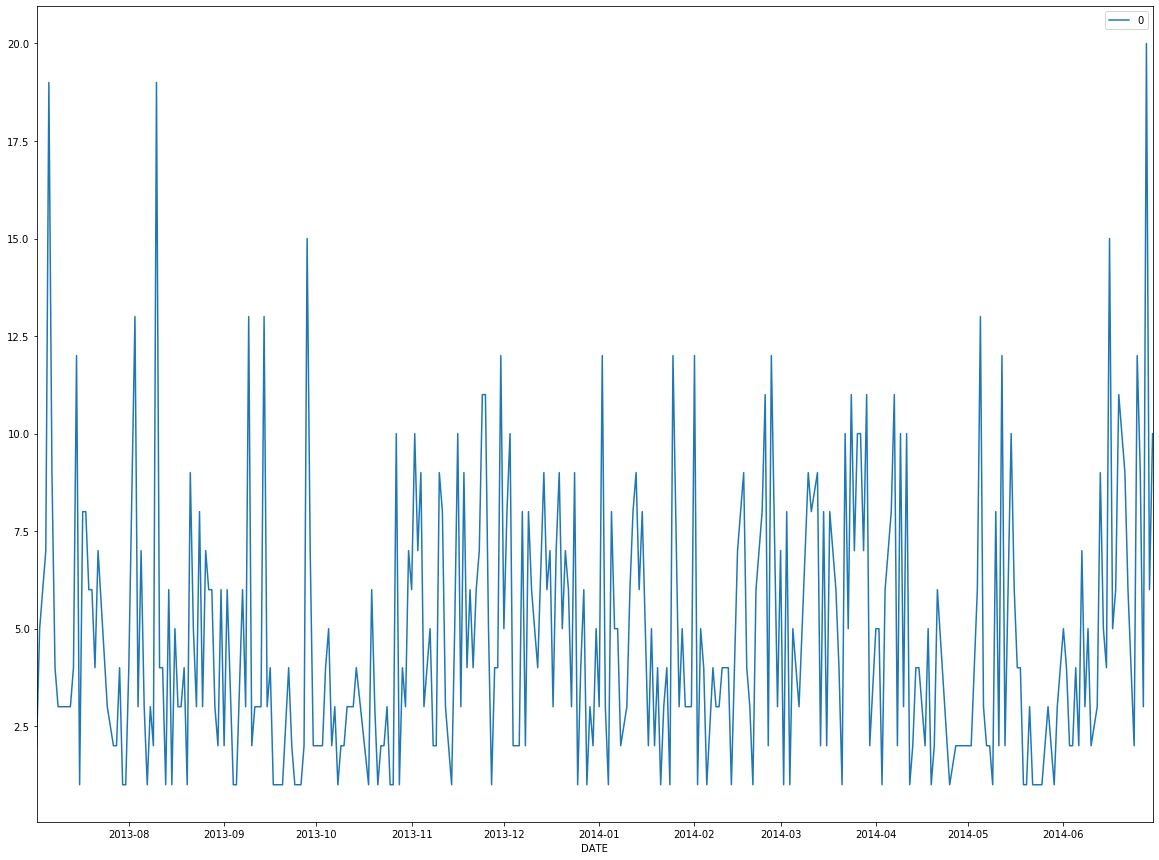

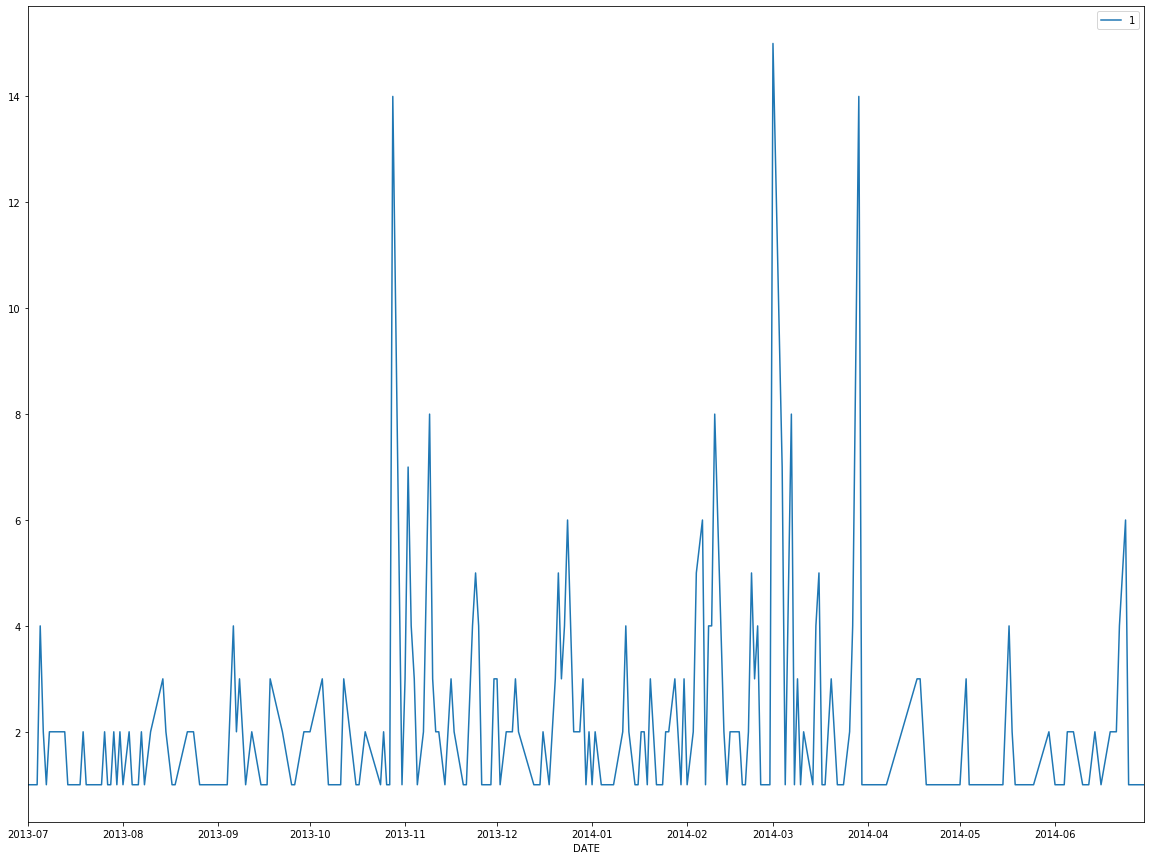

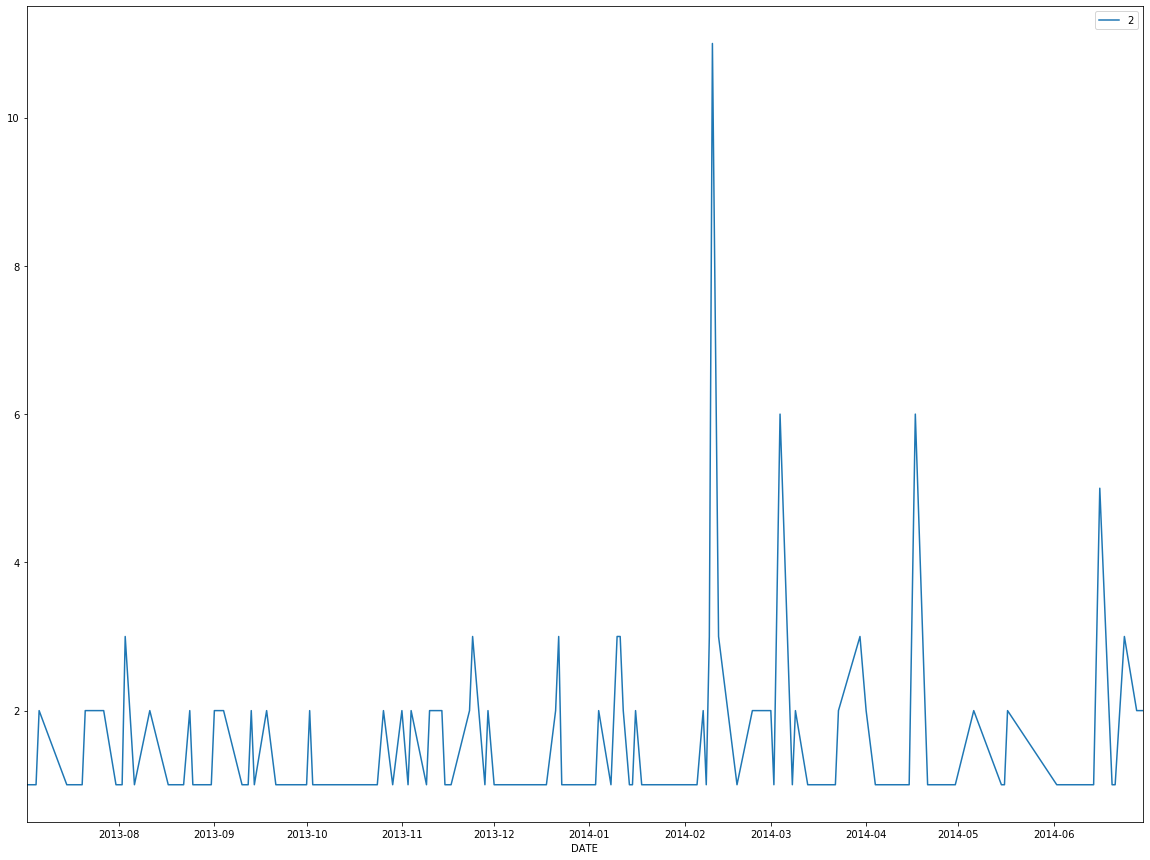

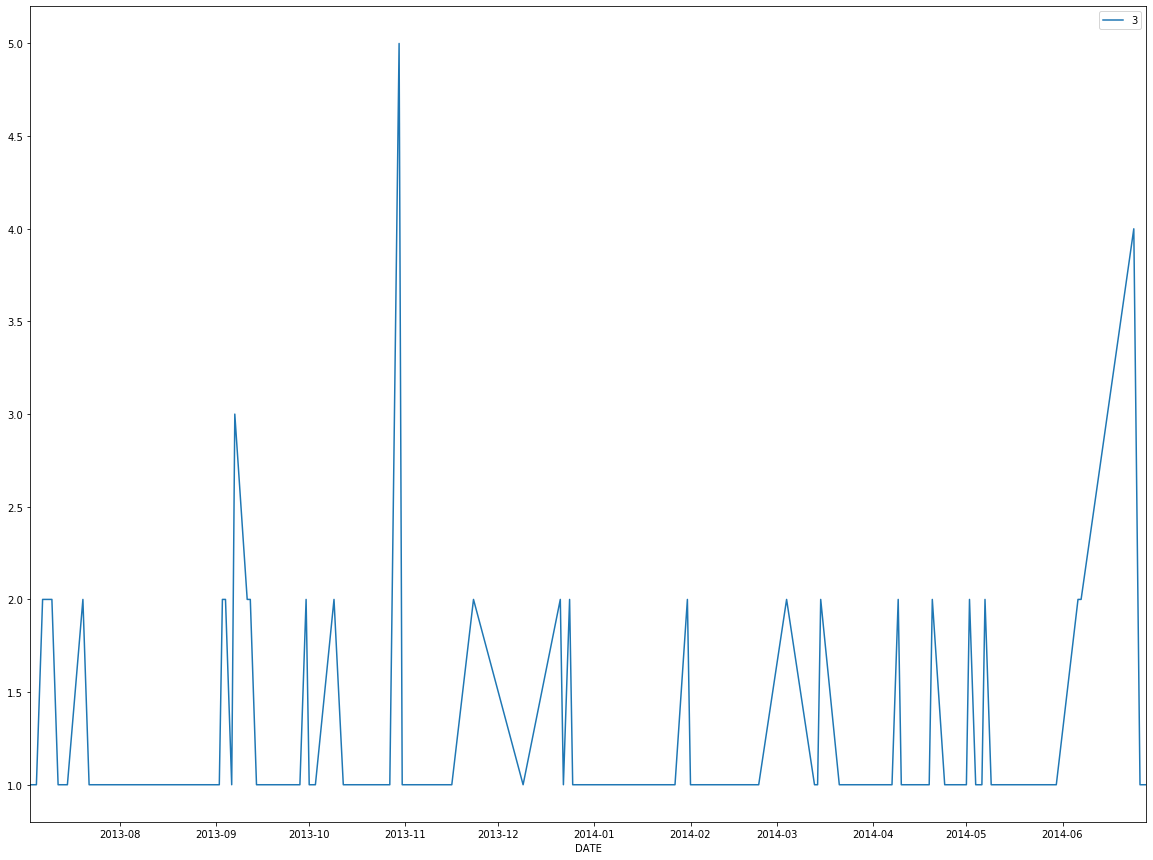

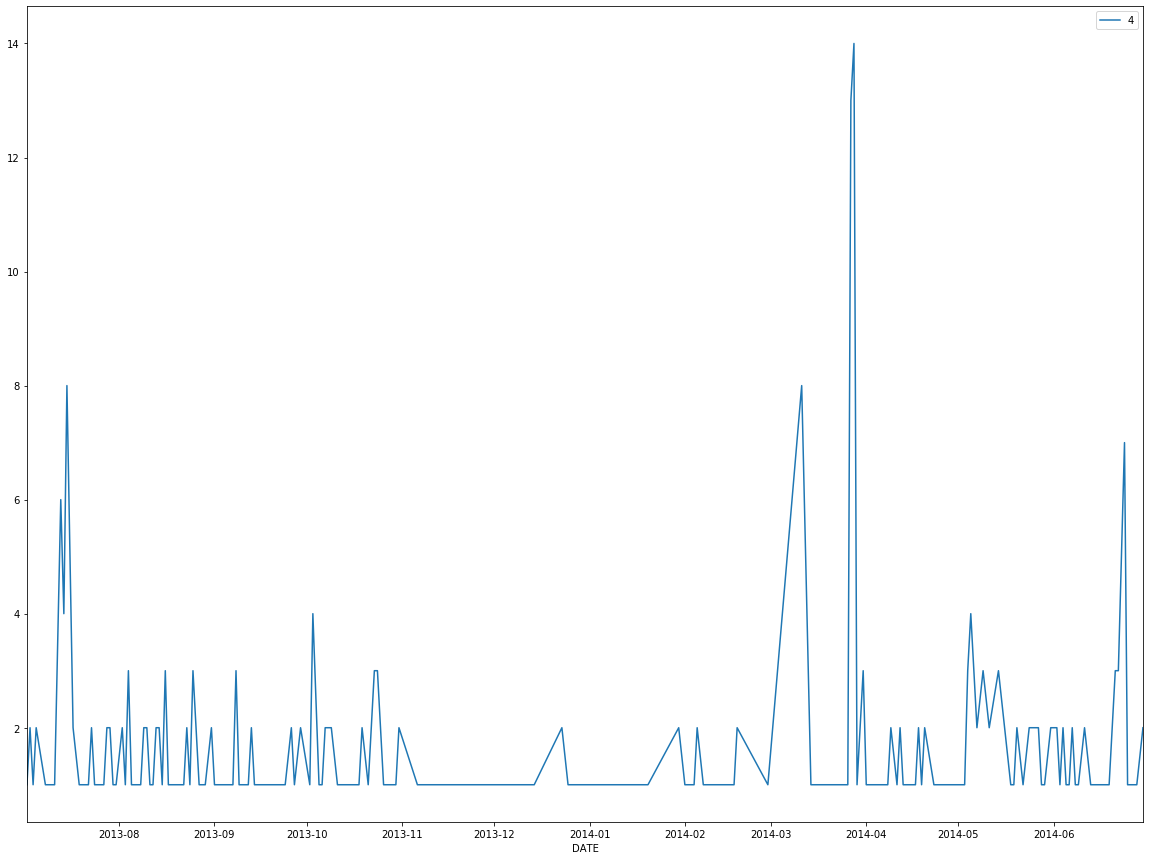

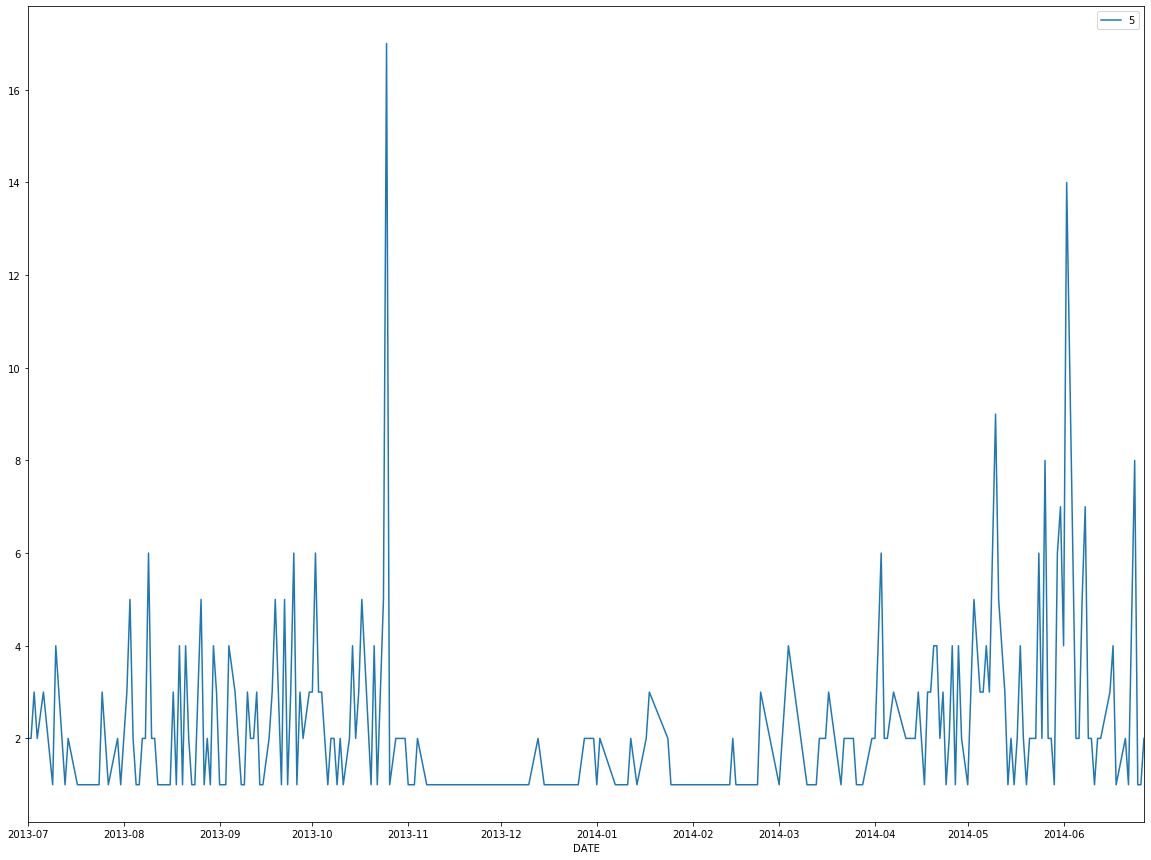

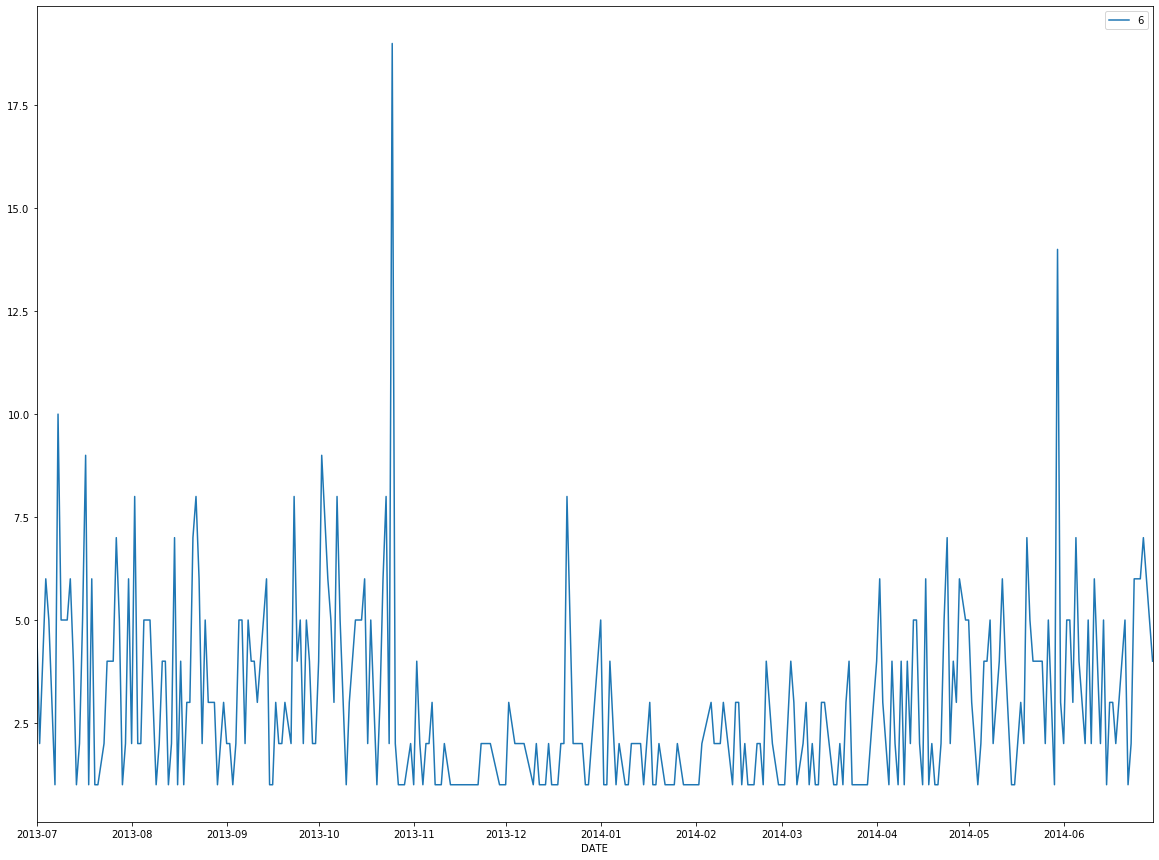

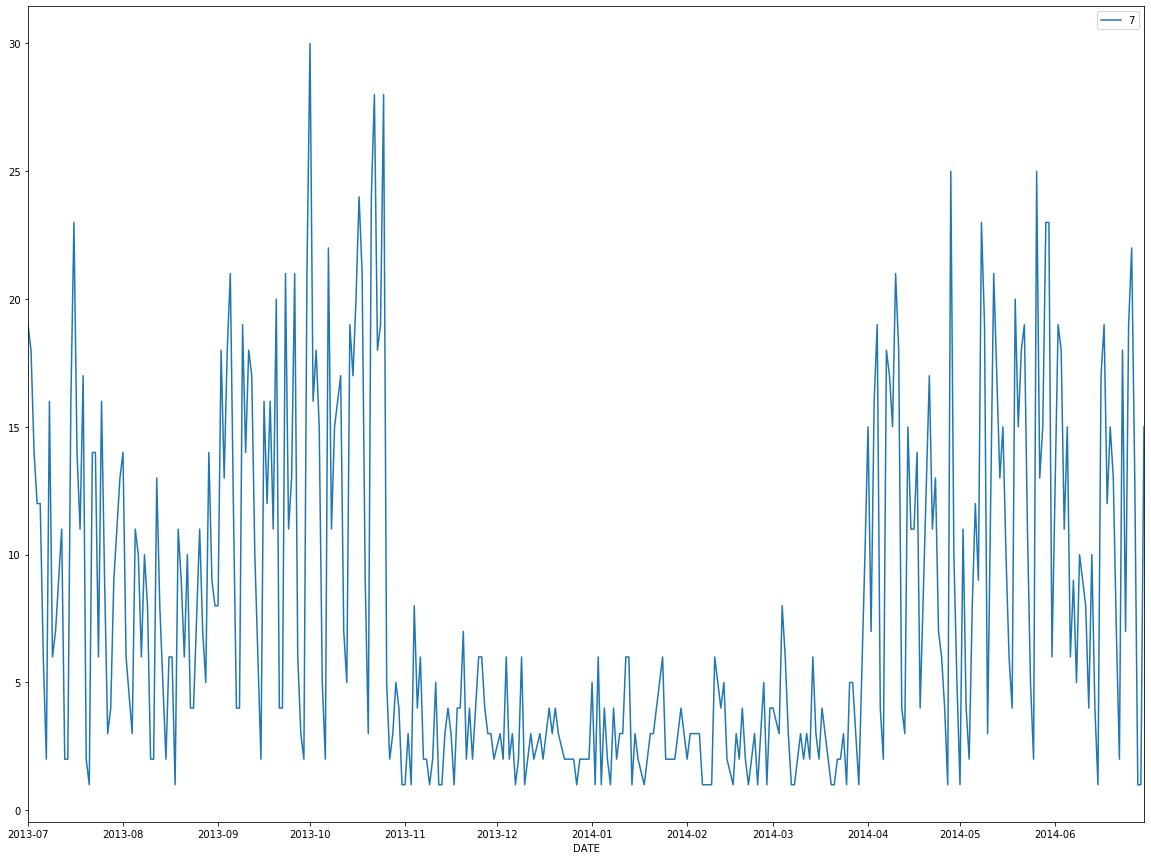

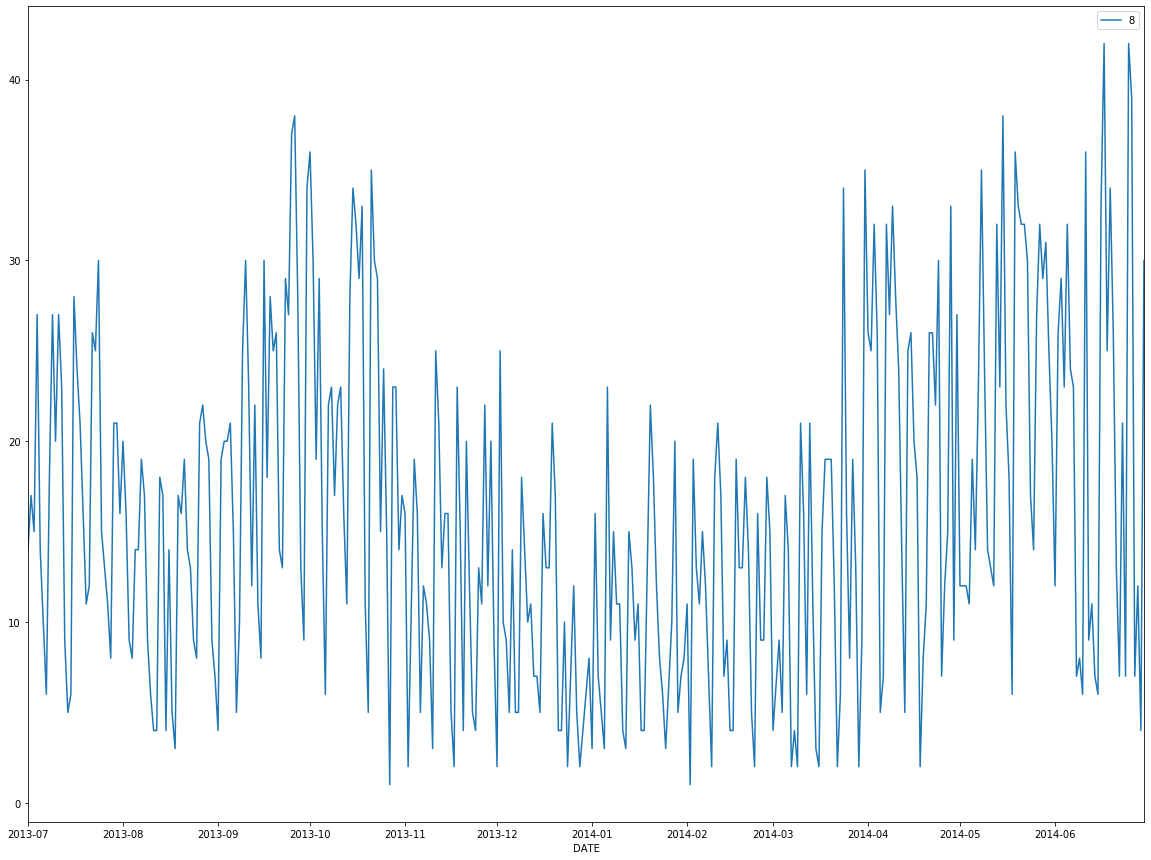

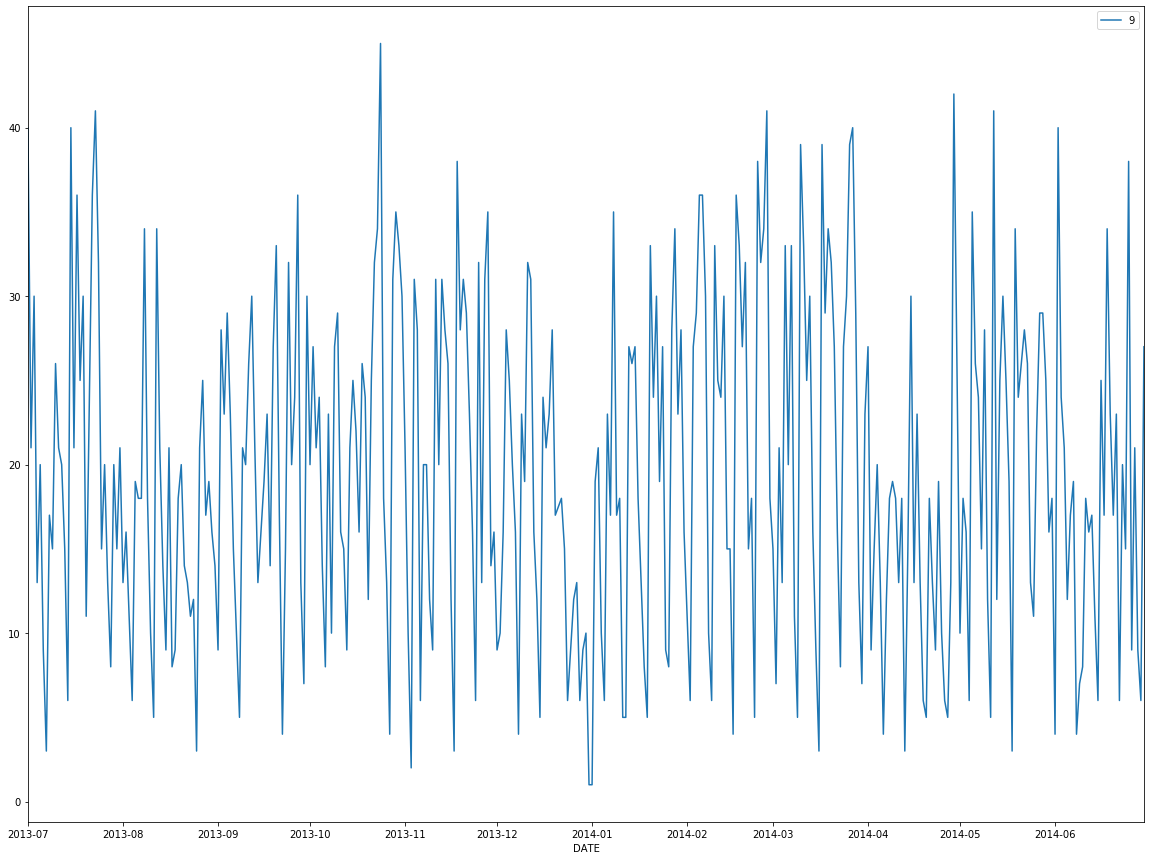

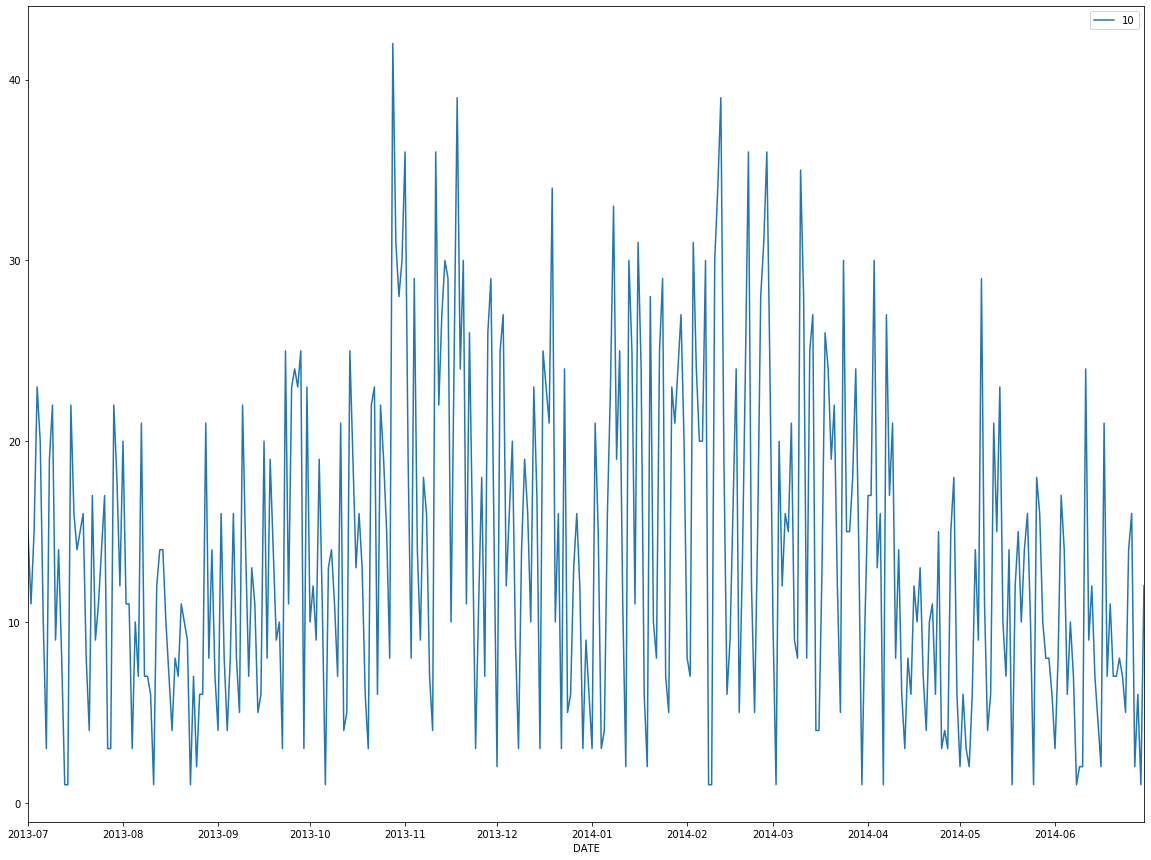

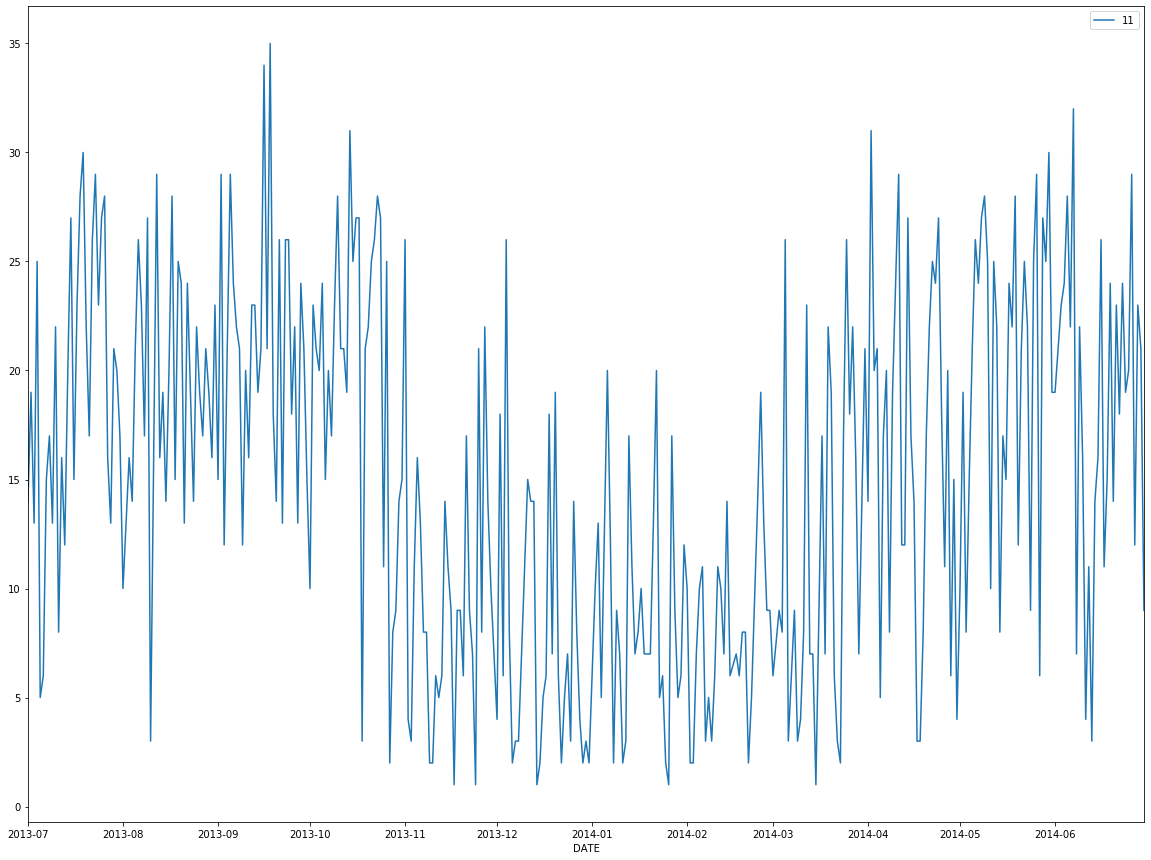

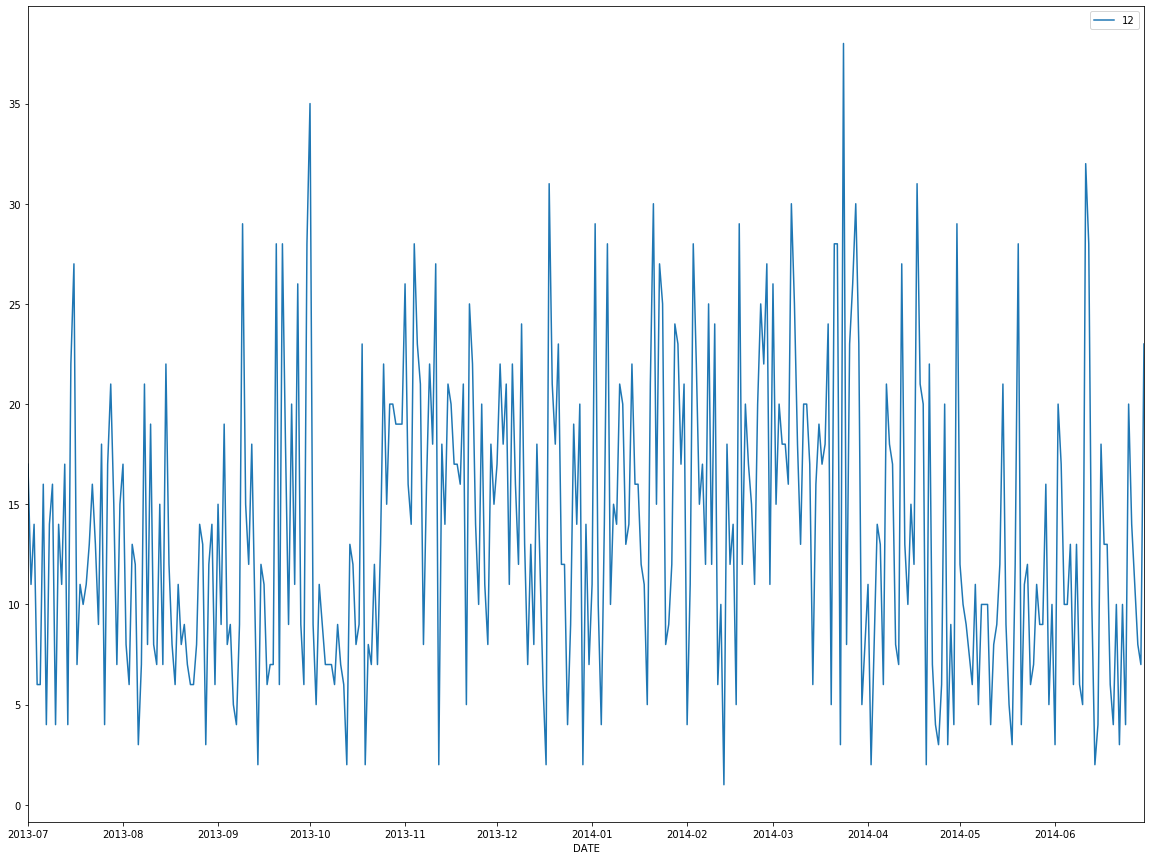

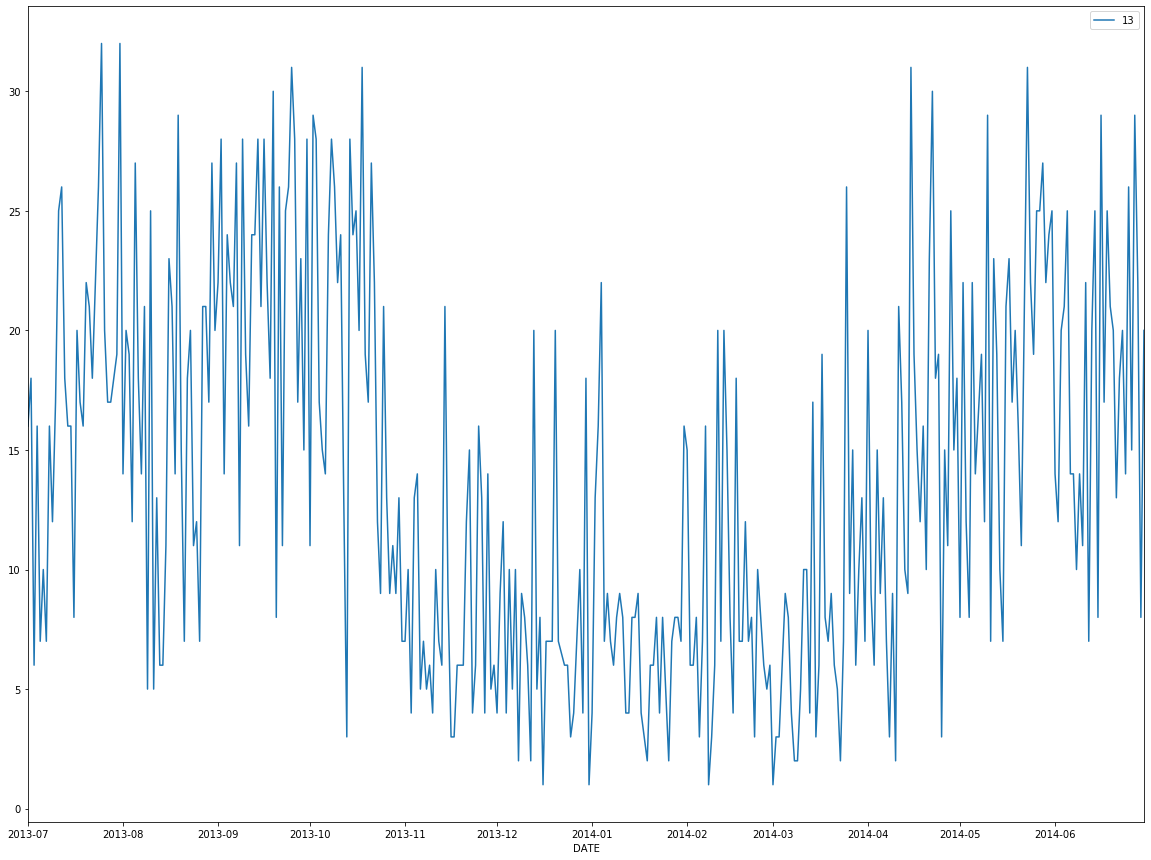

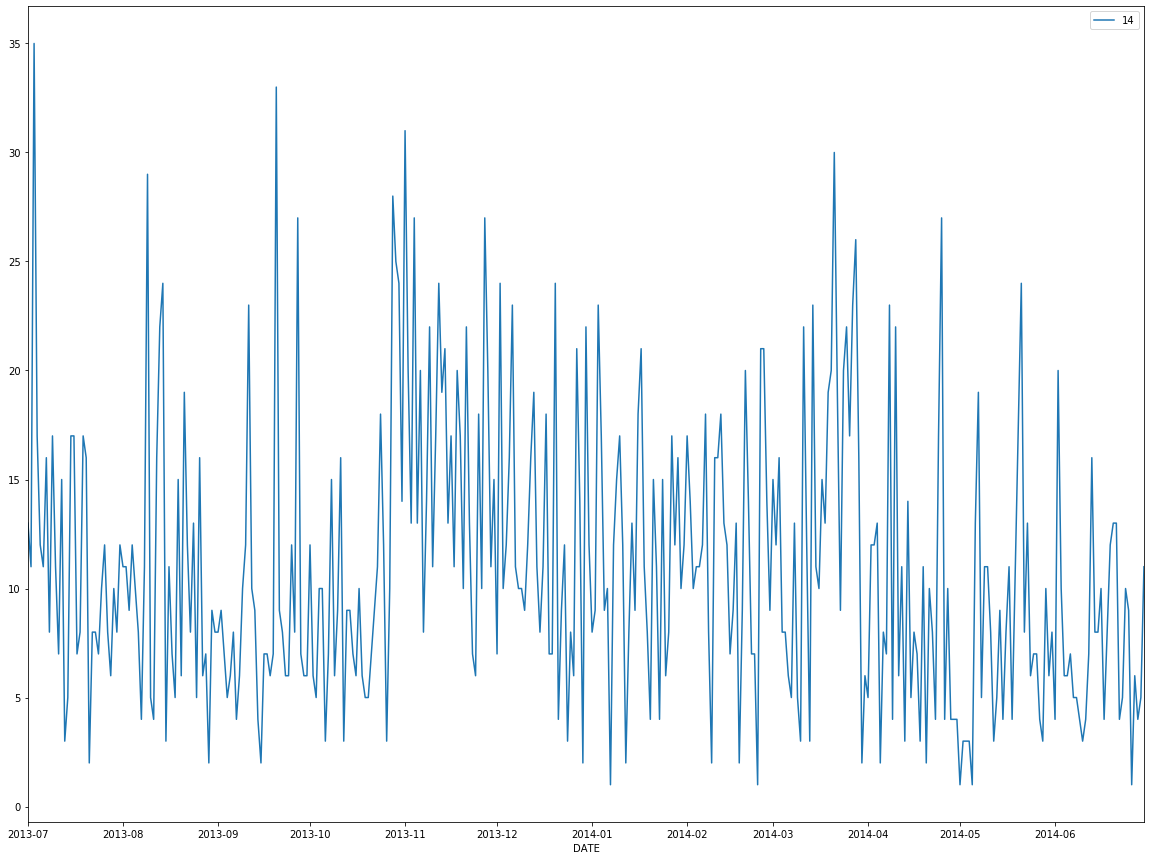

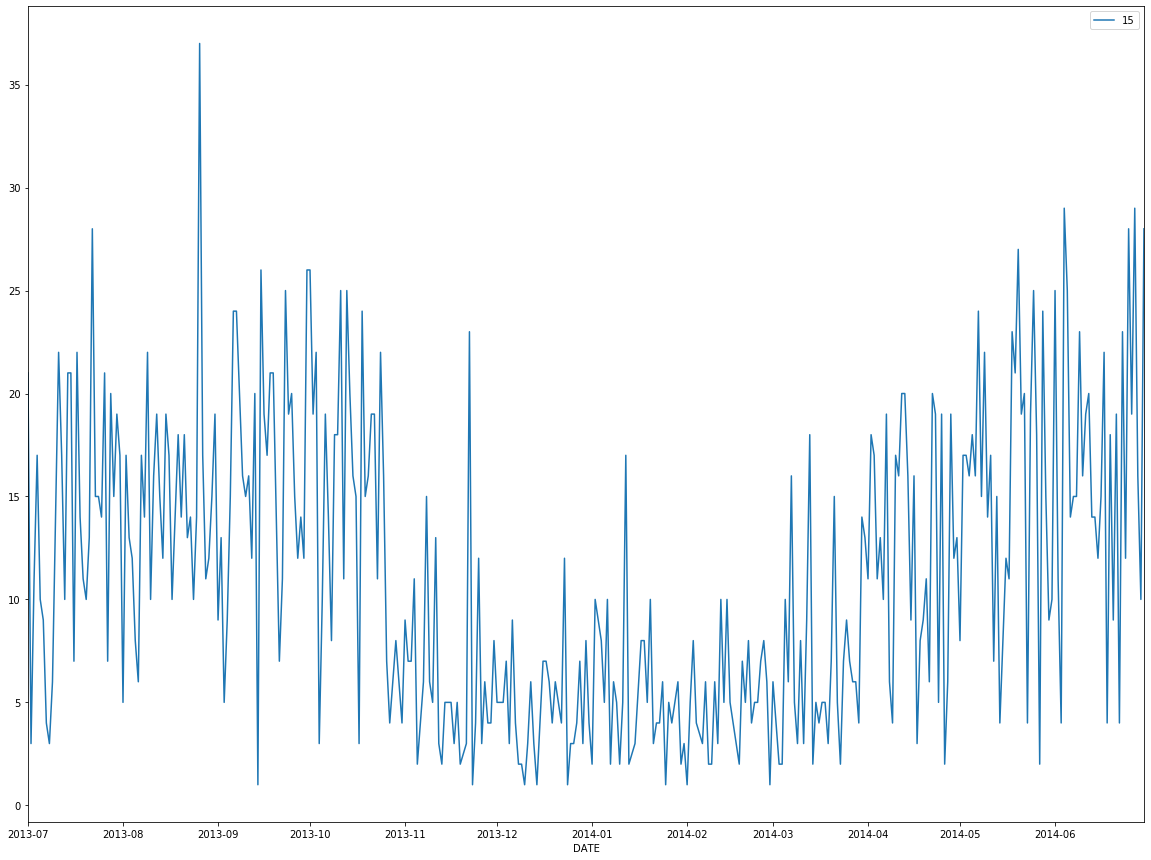

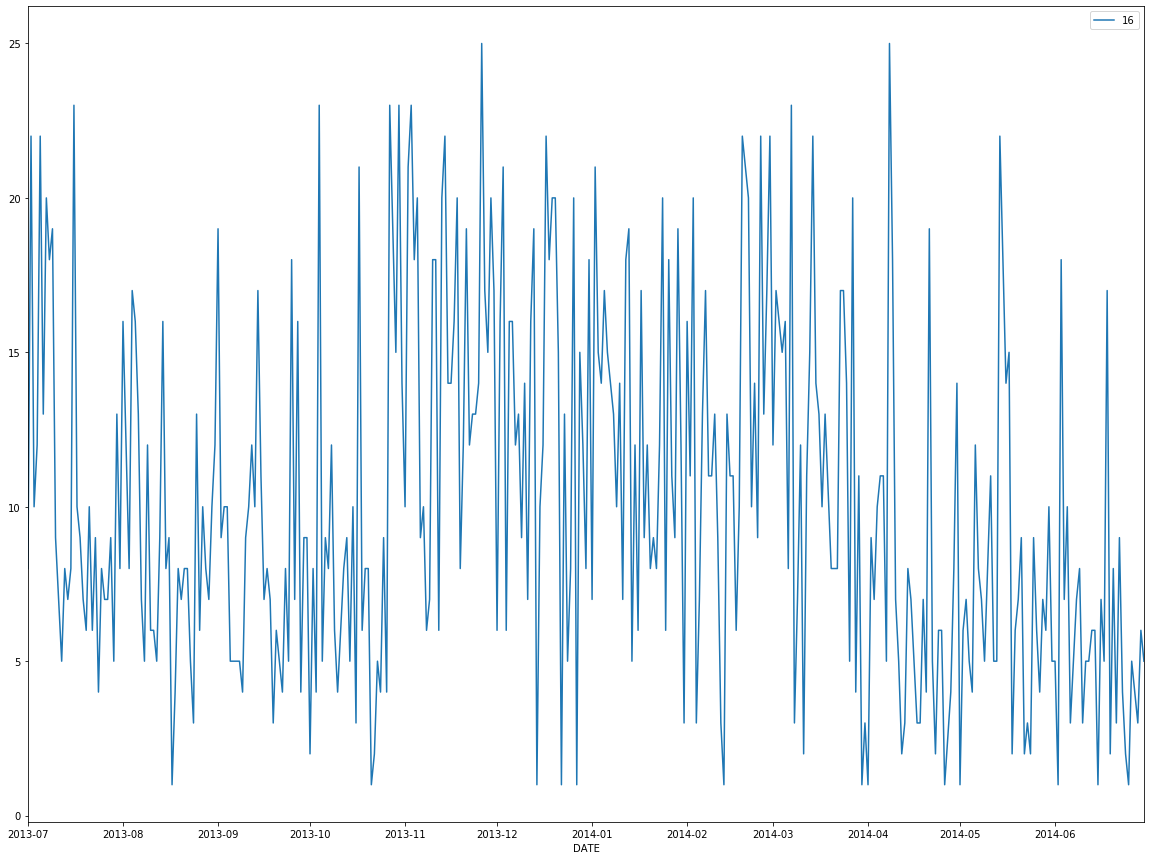

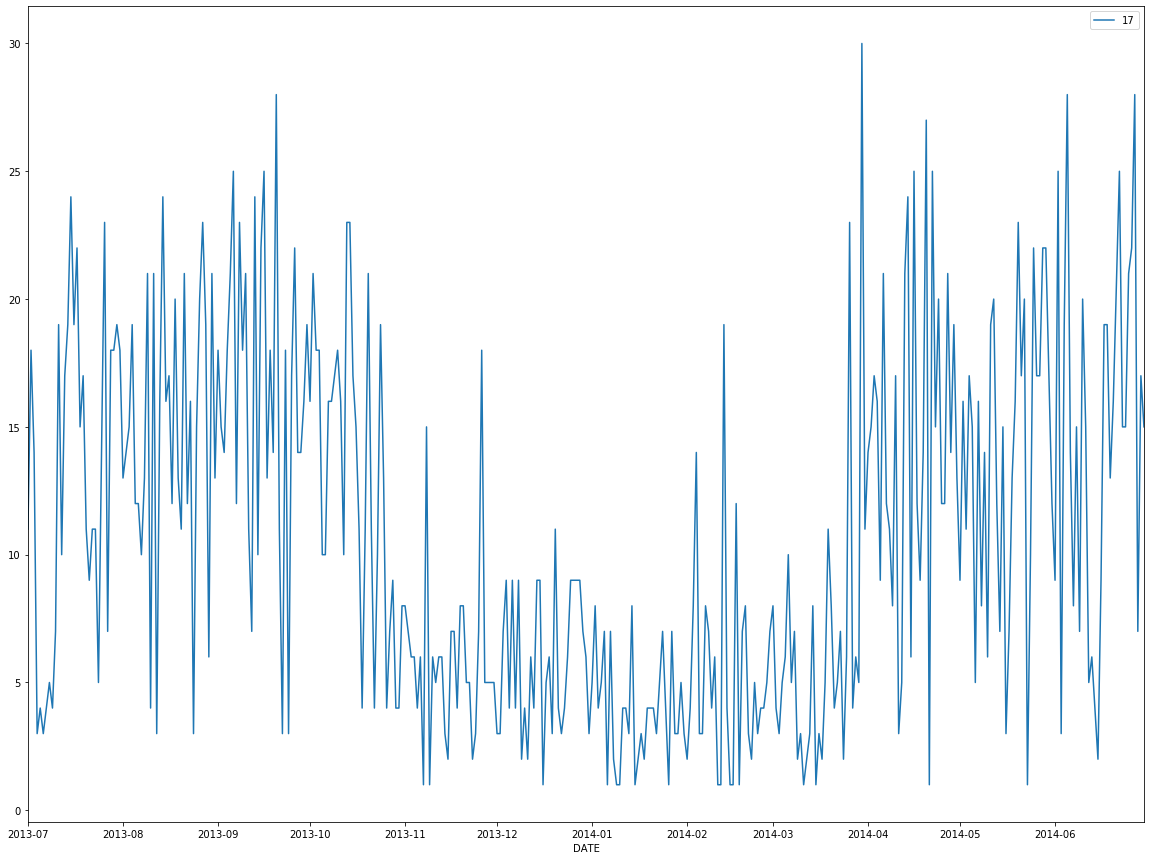

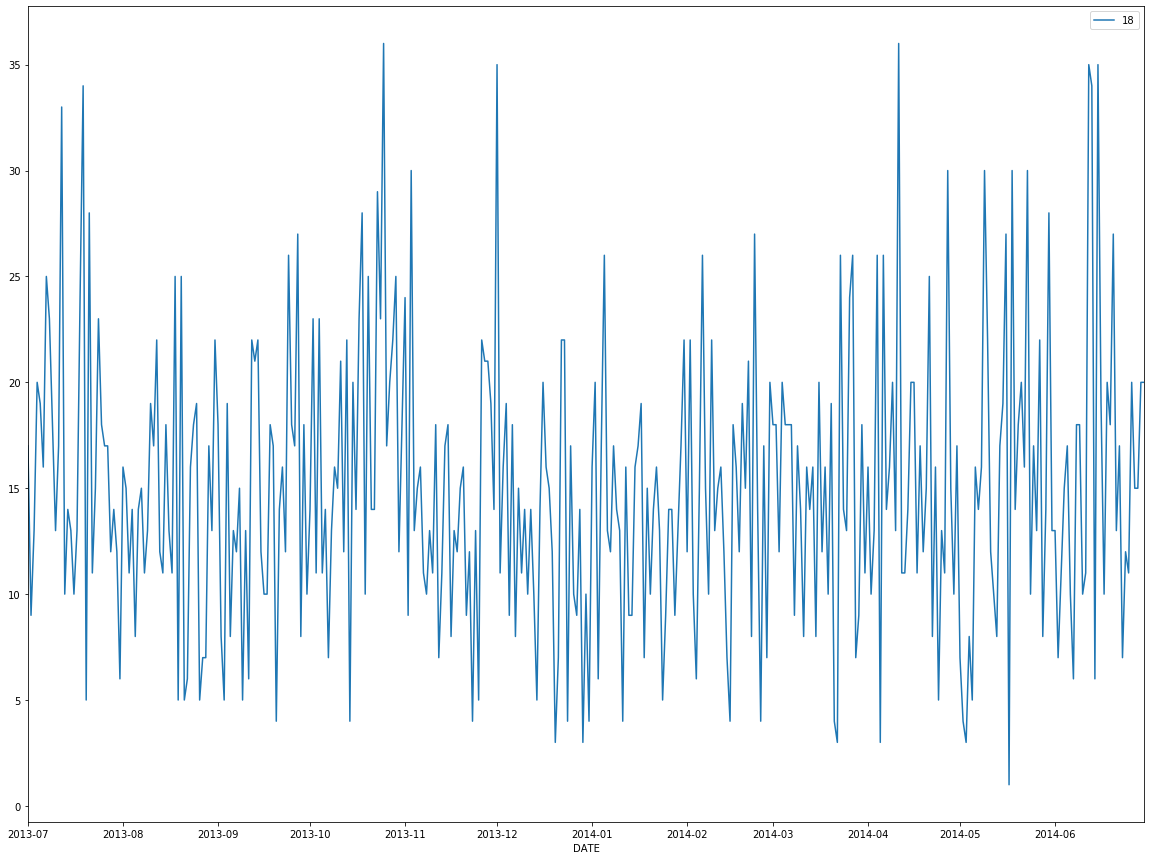

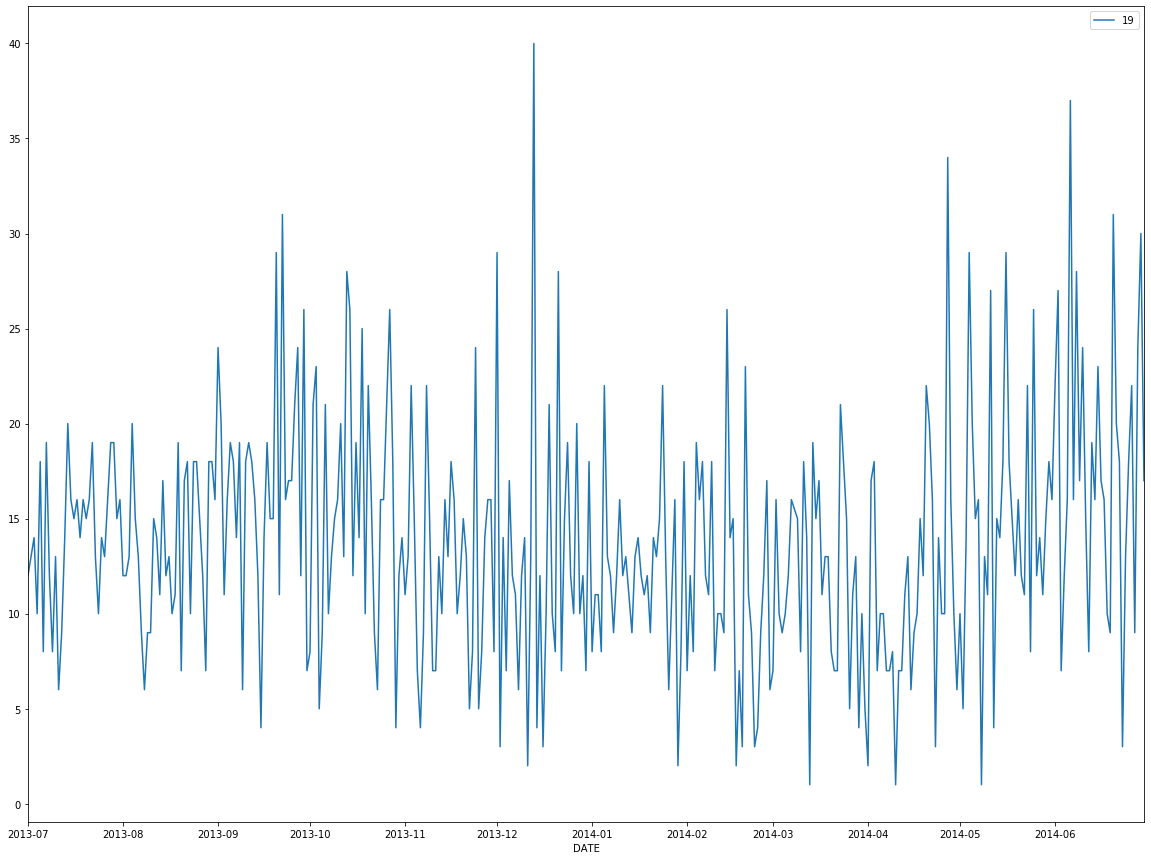

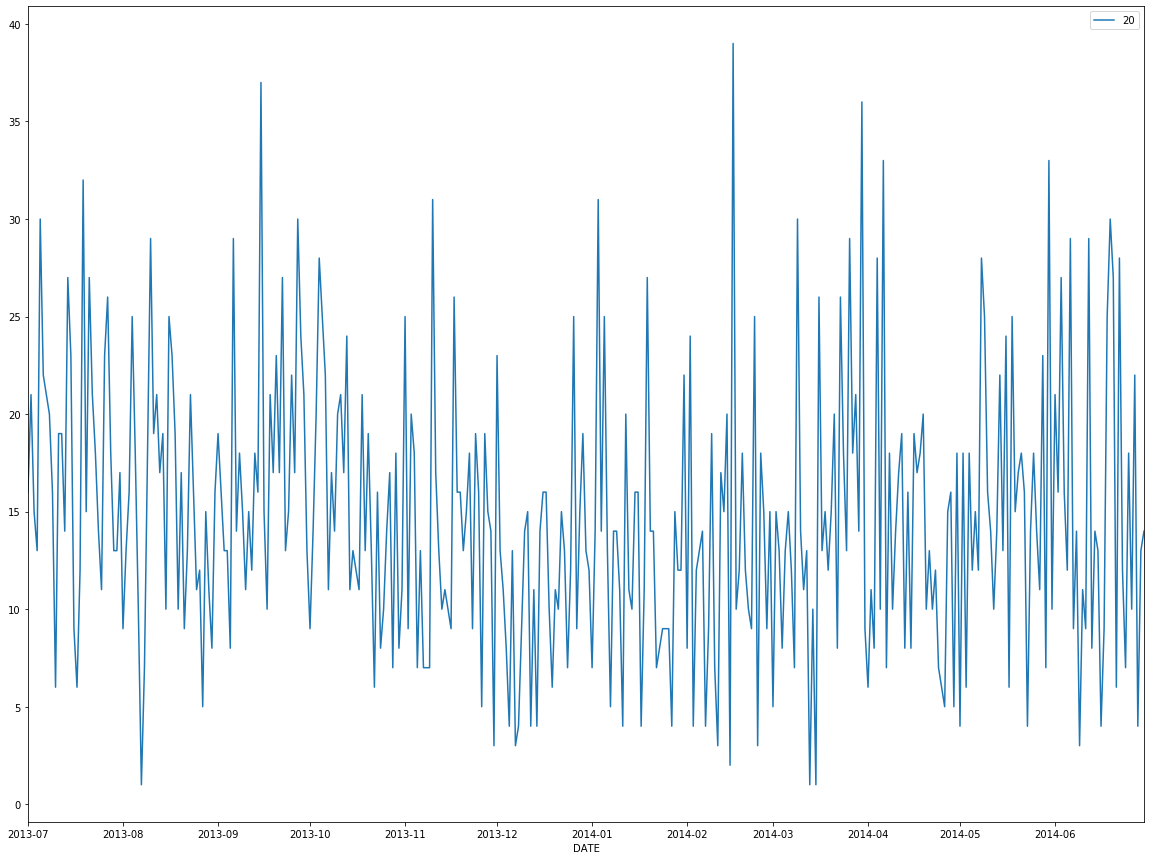

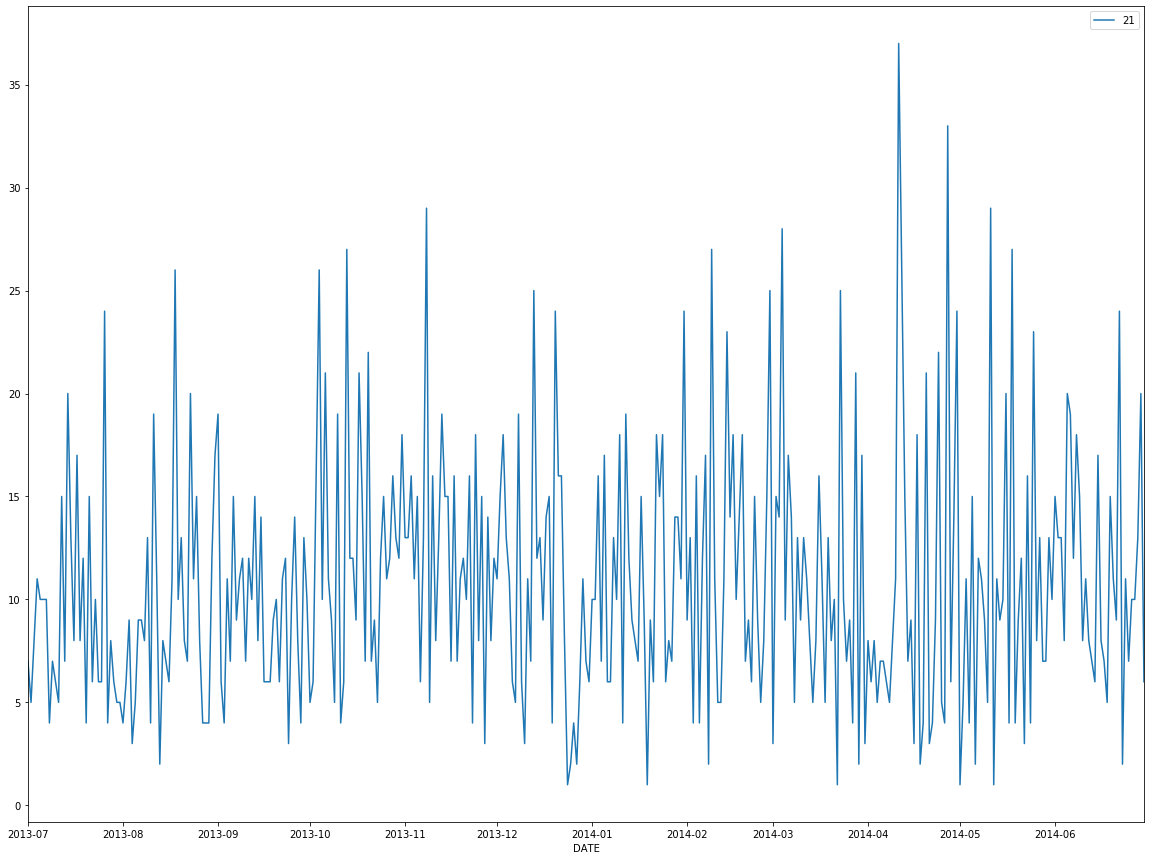

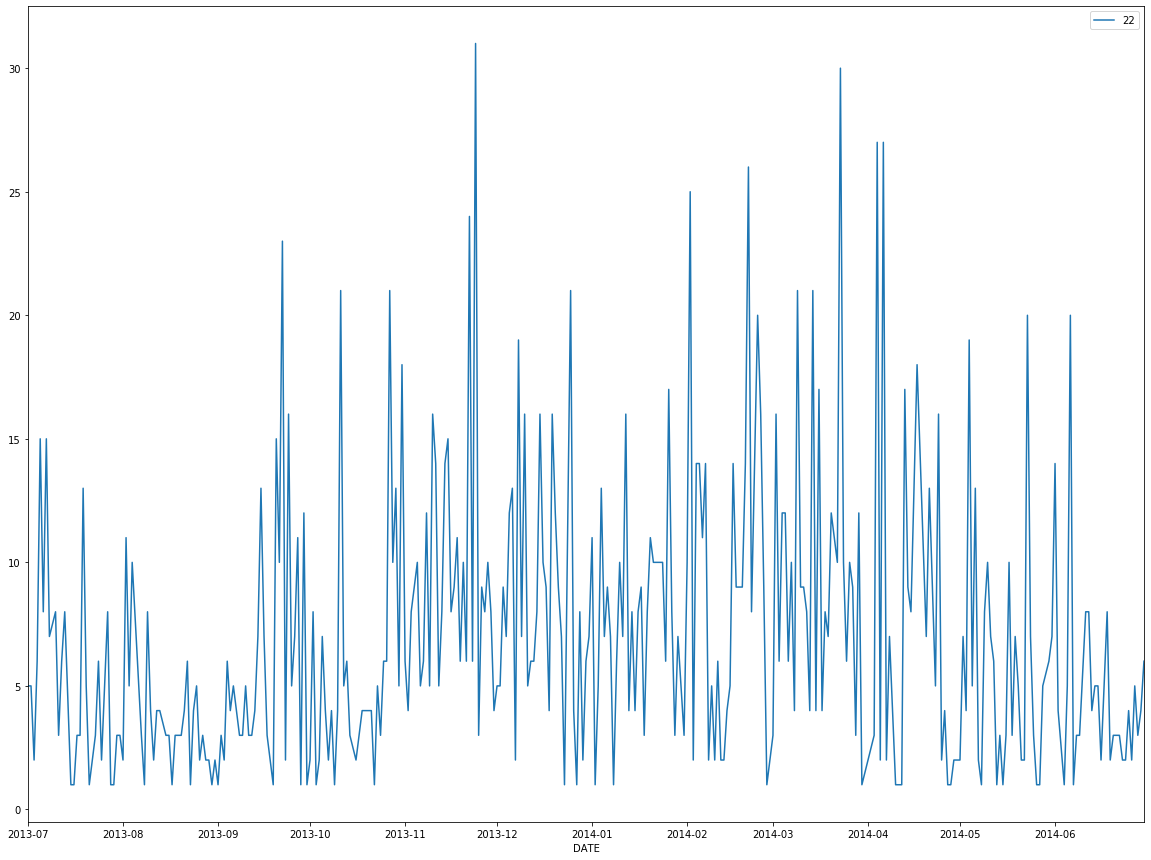

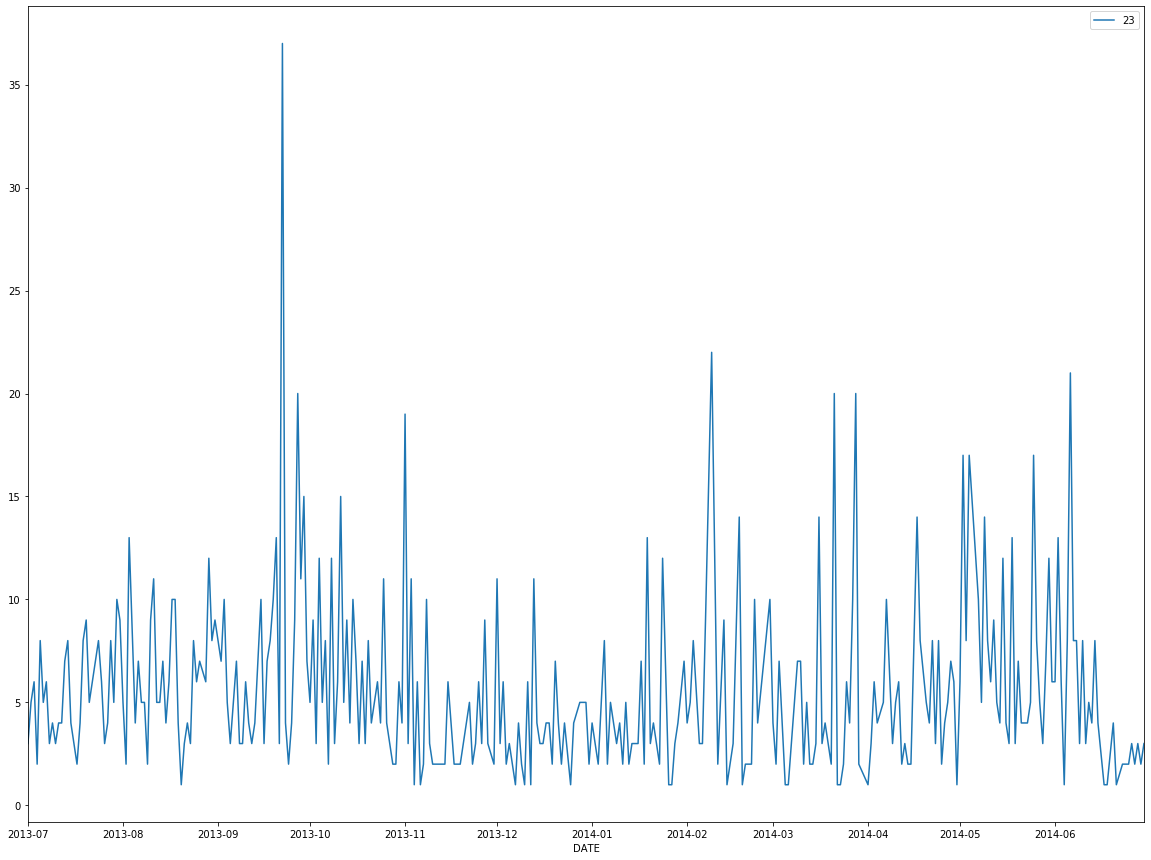

In [12]:
taxi_stands = [15]
for stand in taxi_stands :
    df_temp = df_taxi_stand[df_taxi_stand['ORIGIN_STAND'] == stand][['DATE','HOUR','Trip Count Daily','Trip Count Hourly']]

    #fig, ax = plt.subplots()
    #df_temp[(df_temp['HOUR'] > 7) & (df_temp['HOUR'] < 10)].groupby('HOUR').plot(x='DATE', y='Trip Count Hourly', legend=False, figsize=(20,15))
    for name, group in df_temp.groupby('HOUR'):
        group.plot(x='DATE', y='Trip Count Hourly', figsize=(20,15), label=name)

    plt.show()


In [13]:
df = df_taxi_stand[['DATE','ORIGIN_STAND', 'HOUR', 'Trip Count Hourly', 'Trip Count Daily']]
df = df[df['ORIGIN_STAND'].isin(filtered_taxi_stands)]
df = df.drop_duplicates(subset=['DATE','ORIGIN_STAND','HOUR'], keep='first')

df1 = df.loc[(df['HOUR'] >= 8) & (df['HOUR'] < 22)]
df1.loc[:,'count_Day'] = df1.groupby(['DATE','ORIGIN_STAND'])['Trip Count Hourly'].transform('sum')
df1.drop_duplicates(subset=['DATE','ORIGIN_STAND'], keep='first',inplace=True)
df1.drop(['Trip Count Hourly','HOUR','Trip Count Daily'],axis=1,inplace=True)
print(df1.dtypes)

df2 = df.loc[(df['HOUR'] < 8) | (df['HOUR'] >= 22)]
df2.loc[:,'count_Night'] = df2.groupby(['DATE','ORIGIN_STAND'])['Trip Count Hourly'].transform('sum')
df2.drop_duplicates(subset=['DATE','ORIGIN_STAND'], keep='first',inplace=True)
df2.drop(['Trip Count Hourly','HOUR'],axis=1,inplace=True)
print(df2.dtypes)

df3 = pd.merge(df1, df2, on=['DATE','ORIGIN_STAND'])
print(df1.shape)
print(df2.shape)
print(df3.shape)

DATE             object
ORIGIN_STAND    float64
count_Day       float64
dtype: object
DATE                 object
ORIGIN_STAND        float64
Trip Count Daily    float64
count_Night         float64
dtype: object
(7300, 3)
(7300, 4)
(7300, 5)


/Users/anmol/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/anmol/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/anmol/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

In [14]:
df3['DATE'] = pd.to_datetime(df3['DATE'])
df3['ORIGIN_STAND'] = df3.ORIGIN_STAND.astype(int)
df3['count_Day'] = df3.count_Day.astype(int)
df3['Trip Count Daily'] = df3['Trip Count Daily'].astype(int)
df3['count_Night'] = df3.count_Night.astype(int)
df3.to_csv('df3.csv', index= False)
df3.head()

DATE  ORIGIN_STAND  count_Day  Trip Count Daily  count_Night
0 2013-07-01            15        221               256           35
1 2013-07-01            18        127               146           19
2 2013-07-01            57        131               156           25
3 2013-07-01            23         31                46           15
4 2013-07-01            33         61                74           13

In [17]:
# df4 = df3.drop(columns=['DATE','Trip Count Daily','count_Night'])
# df4 = pd.get_dummies(df3, prefix=['stand_', 'dow_', 'month_','dayofyear_','weekofyear_','quarter_'], columns=['ORIGIN_STAND', 'dayofweek', 'month','dayofyear','weekofyear','quarter'])
#df4 = df3

df4 = df4.drop(columns=['dayofyear','weekofyear','quarter'])
df4 = pd.get_dummies(df4, prefix=['stand', 'dow', 'month'], columns=['ORIGIN_STAND', 'dayofweek', 'month'])
df4.loc[:, df4.columns != 'count_Day']


stand_6  stand_7  stand_9  stand_12  stand_13  stand_14  stand_15  \
0           0        0        0         0         0         0         1   
1           0        0        0         0         0         0         0   
2           0        0        0         0         0         0         0   
3           0        0        0         0         0         0         0   
4           0        0        0         0         0         0         0   
...       ...      ...      ...       ...       ...       ...       ...   
7295        0        0        0         0         0         0         0   
7296        0        0        0         0         0         0         0   
7297        0        0        0         0         0         0         0   
7298        1        0        0         0         0         0         0   
7299        0        0        0         0         0         0         0   

      stand_18  stand_21  stand_23  ...  month_3  month_4  month_5  month_6  \
0            0         0         0  ...        0        0        0        0   
1            1         0         0  ...        0        0        0        0   
2            0         0         0  ...        0        0        0        0   
3            0         0         1  ...        0        0        0        0   
4            0         0         0  ...        0        0        0        0   
...        ...       ...       ...  ...      ...      ...      ...      ...   
7295         0         0         0  ...        0        0        0        1   
7296         0         0         1  ...        0        0        0        1   
7297         0         0         0  ...        0        0        0        1   
7298         0         0         0  ...        0        0        0        1   
7299         0         0         0  ...        0        0        0        1   

      month_7  month_8  month_9  month_10  month_11  month_12  
0           1        0        0         0         0         0  
1           1        0        0         0         0         0  
2           1        0        0         0         0         0  
3           1        0        0         0         0         0  
4           1        0        0         0         0         0  
...       ...      ...      ...       ...       ...       ...  
7295        0        0        0         0         0         0  
7296        0        0        0         0         0         0  
7297        0        0        0         0         0         0  
7298        0        0        0         0         0         0  
7299        0        0        0         0         0         0  

[7300 rows x 39 columns]

In [18]:
#df4 = df4[df4['count_Day'] < 150]
X = df4.loc[:, df4.columns != 'count_Day'] #df3[['ORIGIN_STAND','month','dayofweek','dayofyear','weekofyear','quarter']]
y = df4['count_Day']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(5840, 39) (5840,)
(1460, 39) (1460,)


Slope =  -9.941148747243936 Intercept =  0.0
(-9.941148747243936, 'stand_6')
(-2.1776727051186526, 'stand_7')
(31.294608139967075, 'stand_9')
(9.898082738830084, 'stand_12')
(11.011434803180471, 'stand_13')
(-14.85322319185122, 'stand_14')
(144.25691539266478, 'stand_15')
(30.513084984095183, 'stand_18')
(-9.24326427489597, 'stand_21')
(-15.255655451379164, 'stand_23')
(-7.86179705734027, 'stand_25')
(17.294324939200408, 'stand_33')
(-5.2414692777937075, 'stand_34')
(8.815594646402836, 'stand_36')
(-21.665632750416187, 'stand_52')
(13.222001804010555, 'stand_53')
(-18.08678516111268, 'stand_56')
(61.93940365976915, 'stand_57')
(-17.618072051647342, 'stand_60')
(-10.011948981655534, 'stand_61')
(35.89146877540767, 'dow_Friday')
(31.91590615376868, 'dow_Monday')
(19.303039969271353, 'dow_Saturday')
(14.158910445930088, 'dow_Sunday')
(33.059856000289216, 'dow_Thursday')
(31.03649859901379, 'dow_Tuesday')
(30.92310151398518, 'dow_Wednesday')
(9.58128285978811, 'month_1')
(10.43473131552059

0.8516925671623726

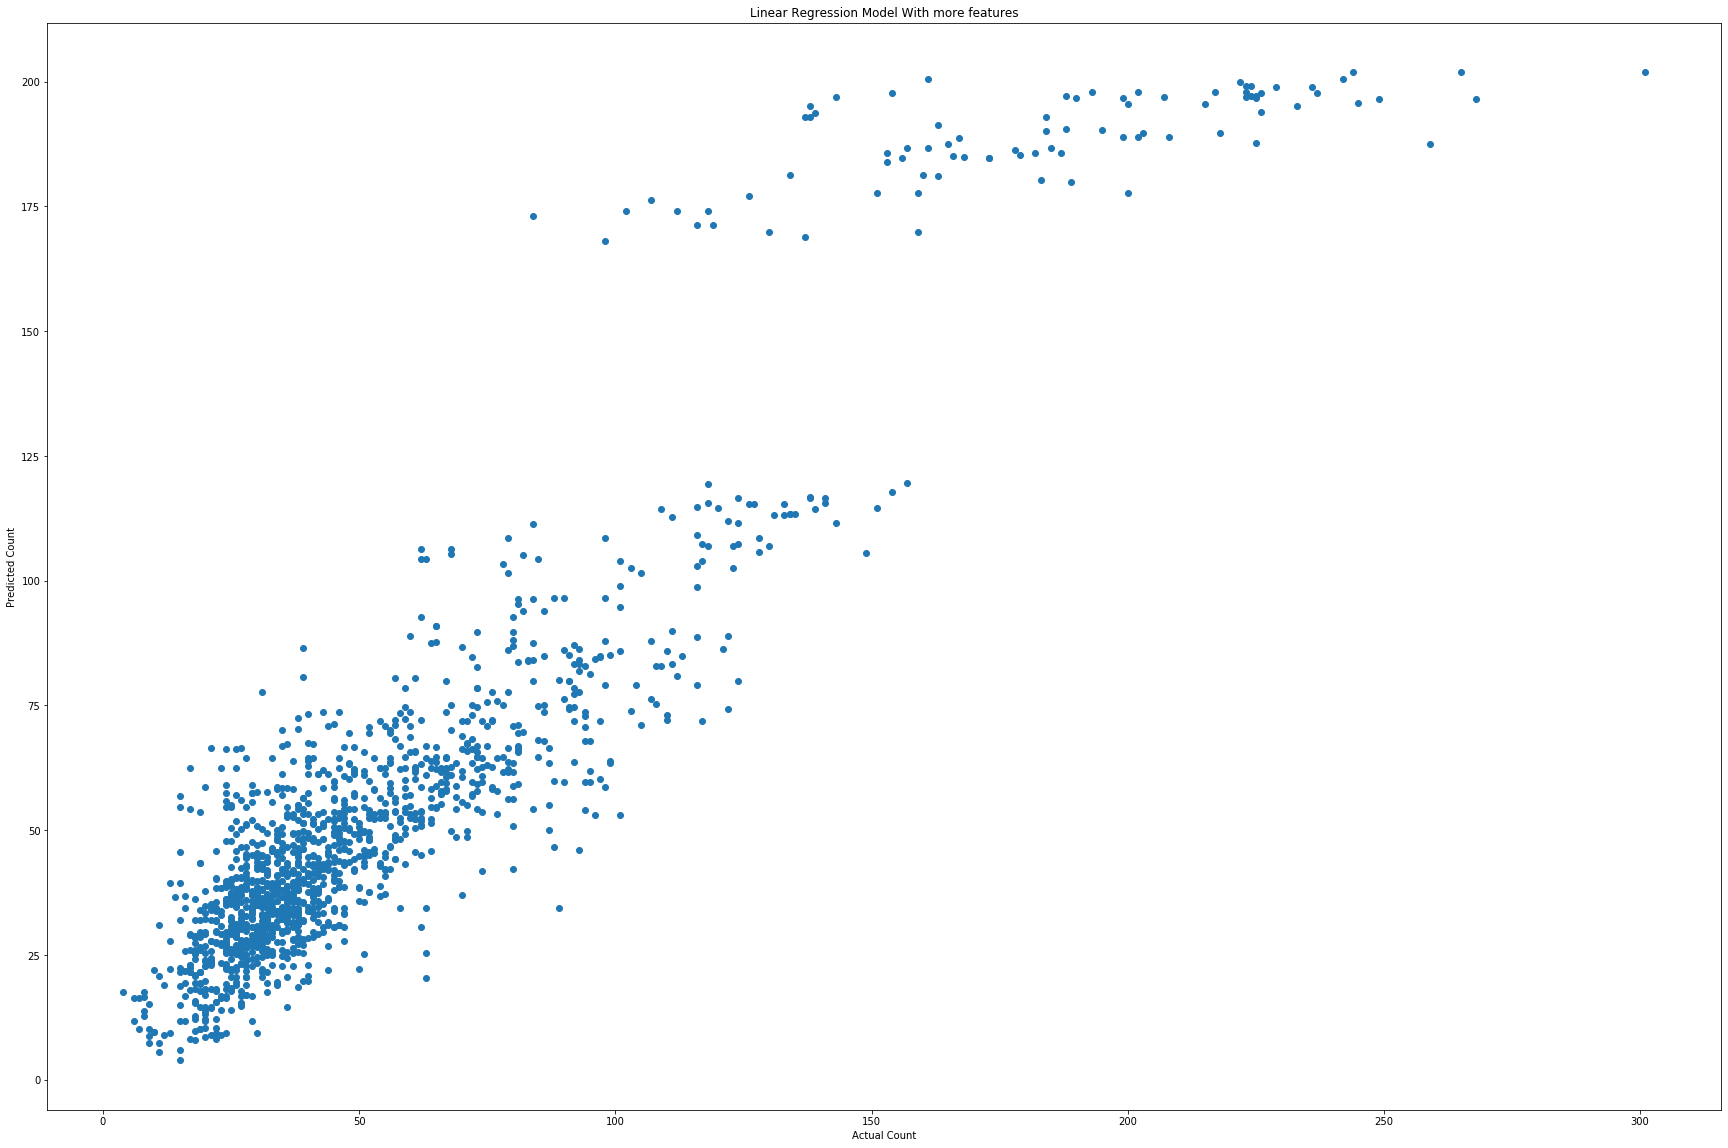

In [19]:
lm = LinearRegression(fit_intercept=False)
lm.fit(X_train,y_train)

m = lm.coef_[0]
b = lm.intercept_
print("Slope = ",m, "Intercept = ",b)
coefficients = list(zip(lm.coef_, X_train))
for elem in coefficients:
    print(elem)
    
predictions_test = lm.predict(X_test)
plt.figure(figsize=(30,20))
plt.scatter(y_test, predictions_test)
plt.xlabel("Actual Count")
plt.ylabel("Predicted Count")
plt.title("Linear Regression Model With more features")
print ("Test Accuracy : ", lm.score(X_test, y_test))

rms = np.sqrt(mean_squared_error(y_test, predictions_test))
print(rms)
r2_score(y_test, predictions_test,multioutput='variance_weighted') 

In [20]:
import pickle
filename = '../model/day_prediction.sav'
pickle.dump(lm, open(filename, 'wb'))

lm_model = pickle.load(open(filename, 'rb'))
result = lm_model.score(X_test, y_test)
print(result)

0.8516925671623726


In [21]:
def predict(stand, date_string) :
    import datetime
    import pickle
    import numpy as np

    date = datetime.datetime.strptime(date_string, "%Y-%m-%d")
    month = date.month
    dayofweek = date.weekday()
    
    #def get_month_dummies(month) :
    month_1 = 0
    month_2 = 0
    month_3 = 0
    month_4 = 0
    month_5 = 0
    month_6 = 0
    month_7 = 0
    month_8 = 0
    month_9 = 0
    month_10 = 0
    month_11 = 0
    month_12 = 0
    if(month == 1) : month_1 = 1
    if(month == 2) : month_2 = 1
    if(month == 3) : month_3 = 1
    if(month == 4) : month_4 = 1
    if(month == 5) : month_5 = 1
    if(month == 6) : month_6 = 1
    if(month == 7) : month_7 = 1
    if(month == 8) : month_8 = 1
    if(month == 9) : month_9 = 1
    if(month == 10) : month_10 = 1
    if(month == 11) : month_11 = 1
    if(month == 12) : month_12 = 1
    #return month_1, month_2, month_3, month_4, month_5, month_6, month_7, month_8, month_9, month_10, month_11, month_12  

    #def get_day_of_week_dummies(dayofweek) :
    dow_Friday = 0
    dow_Monday = 0
    dow_Saturday = 0
    dow_Sunday = 0
    dow_Thursday = 0
    dow_Tuesday = 0
    dow_Wednesday = 0
    if(dayofweek == 0) : dow_Monday = 1
    if(dayofweek == 1) : dow_Tuesday = 1
    if(dayofweek == 2) : dow_Wednesday = 1
    if(dayofweek == 3) : dow_Thursday = 1
    if(dayofweek == 4) : dow_Friday = 1
    if(dayofweek == 5) : dow_Saturday = 1
    if(dayofweek == 6) : dow_Sunday = 1
    #return dow_Friday, dow_Monday, dow_Saturday, dow_Sunday, dow_Thursday, dow_Tuesday, dow_Wednesday

    #def get_stand_dummies(stand) :
    stand_6 = 0
    stand_7 = 0
    stand_9 = 0
    stand_12 = 0
    stand_13 = 0
    stand_14 = 0
    stand_15 = 0
    stand_18 = 0
    stand_21 = 0
    stand_23 = 0
    stand_25 = 0
    stand_33 = 0
    stand_34 = 0
    stand_36 = 0
    stand_52 = 0
    stand_53 = 0
    stand_56 = 0
    stand_57 = 0
    stand_60 = 0
    stand_61 = 0
    if(stand == 6) : stand_6 = 1
    if(stand == 7) : stand_7 = 1
    if(stand == 9) : stand_9 = 1
    if(stand == 12) : stand_12 = 1
    if(stand == 13) : stand_13 = 1
    if(stand == 14) : stand_14 = 1
    if(stand == 15) : stand_15 = 1
    if(stand == 18) : stand_18 = 1
    if(stand == 21) : stand_21 = 1
    if(stand == 23) : stand_23 = 1
    if(stand == 25) : stand_25 = 1
    if(stand == 33) : stand_33 = 1
    if(stand == 34) : stand_34 = 1
    if(stand == 36) : stand_36 = 1
    if(stand == 52) : stand_52 = 1
    if(stand == 53) : stand_53 = 1
    if(stand == 56) : stand_56 = 1
    if(stand == 57) : stand_57 = 1
    if(stand == 60) : stand_60 = 1
    if(stand == 61) : stand_61 = 1
    #return stand_6, stand_7, stand_9, stand_12, stand_13, stand_14, stand_15, stand_18, stand_21, stand_23, stand_25, stand_33, stand_34, stand_36, stand_52, stand_53, stand_56, stand_57, stand_60, stand_61
    
    filename = '../model/day_prediction.sav'
    lm_model = pickle.load(open(filename, 'rb'))
    result = int(lm_model.predict(np.array((
        stand_6, stand_7, stand_9, stand_12, stand_13, stand_14, stand_15, stand_18,
        stand_21, stand_23, stand_25, stand_33, stand_34, stand_36, stand_52, stand_53,
        stand_56, stand_57, stand_60, stand_61, 
        dow_Friday, dow_Monday, dow_Saturday, dow_Sunday, dow_Thursday, dow_Tuesday, dow_Wednesday,
        month_1, month_2, month_3, month_4, month_5, month_6, month_7, month_8, month_9, month_10, month_11, month_12)).reshape(1, -1)))
    return result

date_string = '2019-11-18'
stand = 15
print(predict(stand, date_string))


193


In [22]:
import datetime
import pickle
import numpy as np

def get_month_dummies(month) :
    month_1 = 0
    month_2 = 0
    month_3 = 0
    month_4 = 0
    month_5 = 0
    month_6 = 0
    month_7 = 0
    month_8 = 0
    month_9 = 0
    month_10 = 0
    month_11 = 0
    month_12 = 0
    if(month == 1) : month_1 = 1
    if(month == 2) : month_2 = 1
    if(month == 3) : month_3 = 1
    if(month == 4) : month_4 = 1
    if(month == 5) : month_5 = 1
    if(month == 6) : month_6 = 1
    if(month == 7) : month_7 = 1
    if(month == 8) : month_8 = 1
    if(month == 9) : month_9 = 1
    if(month == 10) : month_10 = 1
    if(month == 11) : month_11 = 1
    if(month == 12) : month_12 = 1
    return month_1, month_2, month_3, month_4, month_5, month_6, month_7, month_8, month_9, month_10, month_11, month_12  

def get_day_of_week_dummies(dayofweek) :
    dow_Friday = 0
    dow_Monday = 0
    dow_Saturday = 0
    dow_Sunday = 0
    dow_Thursday = 0
    dow_Tuesday = 0
    dow_Wednesday = 0
    if(dayofweek == 0) : dow_Monday = 1
    if(dayofweek == 1) : dow_Tuesday = 1
    if(dayofweek == 2) : dow_Wednesday = 1
    if(dayofweek == 3) : dow_Thursday = 1
    if(dayofweek == 4) : dow_Friday = 1
    if(dayofweek == 5) : dow_Saturday = 1
    if(dayofweek == 6) : dow_Sunday = 1
    return dow_Friday, dow_Monday, dow_Saturday, dow_Sunday, dow_Thursday, dow_Tuesday, dow_Wednesday

def get_stand_dummies(stand) :
    stand_6 = 0
    stand_7 = 0
    stand_9 = 0
    stand_12 = 0
    stand_13 = 0
    stand_14 = 0
    stand_15 = 0
    stand_18 = 0
    stand_21 = 0
    stand_23 = 0
    stand_25 = 0
    stand_33 = 0
    stand_34 = 0
    stand_36 = 0
    stand_52 = 0
    stand_53 = 0
    stand_56 = 0
    stand_57 = 0
    stand_60 = 0
    stand_61 = 0
    if(stand == 6) : stand_6 = 1
    if(stand == 7) : stand_7 = 1
    if(stand == 9) : stand_9 = 1
    if(stand == 12) : stand_12 = 1
    if(stand == 13) : stand_13 = 1
    if(stand == 14) : stand_14 = 1
    if(stand == 15) : stand_15 = 1
    if(stand == 18) : stand_18 = 1
    if(stand == 21) : stand_21 = 1
    if(stand == 23) : stand_23 = 1
    if(stand == 25) : stand_25 = 1
    if(stand == 33) : stand_33 = 1
    if(stand == 34) : stand_34 = 1
    if(stand == 36) : stand_36 = 1
    if(stand == 52) : stand_52 = 1
    if(stand == 53) : stand_53 = 1
    if(stand == 56) : stand_56 = 1
    if(stand == 57) : stand_57 = 1
    if(stand == 60) : stand_60 = 1
    if(stand == 61) : stand_61 = 1
    return stand_6, stand_7, stand_9, stand_12, stand_13, stand_14, stand_15, stand_18, stand_21, stand_23, stand_25, stand_33, stand_34, stand_36, stand_52, stand_53, stand_56, stand_57, stand_60, stand_61

date_string = '2019-11-18'
date = datetime.datetime.strptime(date_string, "%Y-%m-%d")
month = date.month
dayofweek = date.weekday()
print(get_stand_dummies(21) + get_day_of_week_dummies(dayofweek) + get_month_dummies(month))

filename = '../model/day_prediction.sav'
lm_model = pickle.load(open(filename, 'rb'))
result = int(lm_model.predict(np.array(get_stand_dummies(15) + get_day_of_week_dummies(dayofweek) + get_month_dummies(month)).reshape(1, -1)))
print(result)


(0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0)
193


In [23]:
date = '2019-10-18'
stand = 1

# Date = pd.to_datetime(date)
# prediction_df = pd.DataFrame(columns = ['Date','ORIGIN_STAND','month','dayofweek','dayofyear','weekofyear','quarter'])
# temp_df = pd.DataFrame({"Date": Date,
#                         "ORIGIN_STAND" : stand
#                         "month" : D
#                        })
# temp_df['Date'] = pd.to_datetime(date)
# temp_df['month'] = temp_df.Date.dt.month
# temp_df['dayofweek'] = temp_df.Date.dt.weekday_name
# temp_df['dayofyear'] = temp_df.Date.dt.dayofyear
# temp_df['weekofyear'] = temp_df.Date.dt.weekofyear
# temp_df['quarter'] = temp_df.Date.dt.quarter

# prediction_df = prediction_df.append(temp_df)
# #temp_df = pd.get_dummies(temp_df, prefix=['stand_', 'dow_', 'month_','dayofyear_','weekofyear_','quarter_'], columns=['ORIGIN_STAND', 'dayofweek', 'month','dayofyear','weekofyear','quarter'])
# prediction_df['Date'] = pd.to_datetime(date)
# prediction_df

In [ ]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, r2)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

est = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, 
                                max_depth=1, random_state=0, loss='ls').fit(X_train, y_train)
np.sqrt(mean_squared_error(y_test, est.predict(X_test)))
est.estimators_

<H3> ARIMA MODEL </H3>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots()
ax.grid(True)
year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)
year_format = mdates.DateFormatter('%Y')
month_format = mdates.DateFormatter('%m')
ax.xaxis.set_minor_locator(month)
ax.xaxis.grid(True, which = 'minor')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)

plt.plot(df_temp.index, df_temp['Trip Count'], c='blue')
plt.plot(decomposition.trend.index, decomposition.trend, c='red')
plt.rcParams['figure.figsize'] = [15,15]

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
df_taxi_stand[df_taxi_stand['ORIGIN_STAND']==23.0].groupby(['DATE','DAY OF WEEK']).count()['HOUR'].unstack().plot(ax=ax)

In [ ]:
df_taxi_stand.sample(10)

In [ ]:
df_taxi_stand.tail()

In [ ]:
#https://stackoverflow.com/questions/40452759/pandas-latitude-longitude-to-distance-between-successive-rows
#https://pypi.org/project/haversine/